In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import itertools

In [9]:
flex_dir = "dynamic/"
minimal_dir = "min/20211221/8/"
maximal_dir = "max/"

In [3]:
learning_steps = 1024000 * 2
n_steps_value = 2048 * 8
number_of_rollouts = learning_steps / n_steps_value

In [4]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def string_to_list_of_lists(string):
    res = []
    string = string[1:-1]
    string = string.replace(" ", "")
    outer_list = string.split("],")
    for inner_list in outer_list:
        tmp_str = inner_list+"]"
        res.append(tmp_str)
    res[-1] = res[-1][:-1]
    return [_list.strip("[]").split(",") for _list in res]

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def combine_lists_distribution(list_of_text_files, folder_name):
    res = []
    for file in list_of_text_files:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list_of_lists(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

def mean_min_max_distribution(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in itertools.zip_longest(*list_of_lists, fillvalue=0):
        float_elements = [float(x) for x in elements]
        _min.append(min(float_elements))
        _max.append(max(float_elements))
        _mean.append(sum(float_elements)/len(float_elements))
    return _mean, _min, _max

In [5]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_min_max)))
    
    #plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
   # plt.plot(_x, _y_max_mean, color="red")
    plt.grid()
    learning_step_ticks = [i*n_steps_value for i in _x]
    _x_ticks = np.arange(min(learning_step_ticks), max(learning_step_ticks)+1, n_steps_value)
    plt.xticks(_x[::15], _x_ticks[::15], rotation=45)
    
    #plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    #plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    plt.autoscale()
    plt.savefig(f"{metric}.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    for run in last_ten_trajectories:
        _xs = []
        _ys = []
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1]-95) # width / 2 - sprite / 2
        plt.plot(_xs, _ys)
    #plt.show()
    
    
def plot_distribution(last_ten_distributions):
    for run in last_ten_distributions:
        run = sum(run, [])
        _xs = list(range(len(run)))
        _ys = []
        
        for coordinate in run:
            _ys.append(coordinate)
        plt.plot(_xs, _ys, color='g')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    
def plot_complete_distribution(distribution):
    distri_list_flex = [path for path in os.listdir(flex_dir) if distribution in path]
    distri_list_min = [path for path in os.listdir(minimal_dir) if distribution in path]
    distri_list_max = [path for path in os.listdir(maximal_dir) if distribution in path]

    _flex_distris_outer = combine_lists_distribution(distri_list_flex, flex_dir)
    _flex_distri_combined = list(itertools.chain.from_iterable(_flex_distris_outer))

    _min_distris_outer = combine_lists_distribution(distri_list_min, minimal_dir)
    _min_distri_combined = list(itertools.chain.from_iterable(_min_distris_outer))

    _max_distris_outer = combine_lists_distribution(distri_list_max, maximal_dir)
    _max_distri_combined = list(itertools.chain.from_iterable(_max_distris_outer))

    combined_lists = _flex_distri_combined + _min_distri_combined + _max_distri_combined
    _y_combined_mean, _y_combined_min, _y_combined_max = mean_min_max_distribution(combined_lists)

    _x = list(range(len(_y_combined_mean)))

    plt.plot(_x, _y_combined_mean, color="blue")
    plt.fill_between(_x, _y_combined_min, _y_combined_max, alpha=0.3, color="blue", label="dynamic")
    plt.grid()
    plt.savefig(f"distribution_average.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)
    
    
def combine_distri_trajectory(trajectory, distribution):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[0][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[0])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[0]))]
    d_ys = []   
    for coordinate in distribution[0]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination.png",facecolor='white', dpi=300, transparent=False)
    plt.show()
    
                 

In [6]:
def plot_histogram(_type, rollout):
    path = "{}histograms/{}_{}.txt".format(minimal_dir, rollout, _type)
    with open(path, "r") as f:
        data = f.read().split(",")
    # removing parentheses
    data[0] = data[0][1:]
    data[-1] = data[-1][:-1]
    if _type == "agent_angles":
        n_bins = 180
    elif _type == "algo_angles":
        n_bins = 180
    elif _type == "distribution":
        rounded_data = [round(float(num)) for num in data]
        n_bins = abs(max(rounded_data)-min(rounded_data))
    elif _type == "agent_y":
        rounded_data = [round(float(num)) for num in data]
        n_bins = 160
    else:
        print("Wrong type parameter.")
    rounded_data = [round(float(num)) for num in data]
    plt.hist(rounded_data, bins=n_bins)
    plt.savefig("histogram_{}_{}.png".format(_type, rollout), dpi=300)
    

def overlap_histogram(_type, rollouts):
    res = []
    for rollout in rollouts:
        path = "{}histograms/{}_{}.txt".format(minimal_dir, rollout, _type)
        with open(path, "r") as f:
            data = f.read().split(",")
            data[0] = data[0][1:]
            data[-1] = data[-1][:-1]
            rounded_data = [round(float(num)) for num in data]
            res.append(rounded_data)
        
        if _type == "agent_angles":
            n_bins = 180
        elif _type == "algo_angles":
            n_bins = 180
        elif _type == "distribution":
            n_bins = abs(max(rounded_data)-min(rounded_data))
        elif _type == "agent_y":
            n_bins = 160
        else:
            print("Wrong type parameter.")
        
    #plt.hist(res, bins=n_bins)
    for hist in res:
        plt.hist(hist, bins=n_bins, alpha=0.5)
    plt.savefig("histogram_{}_{}_overlap.png".format(_type, rollout), dpi=300)
    
def plot_boxplot(rollouts):
    res = []
    for rollout in rollouts:
        path = "{}histograms/{}_agent_y.txt".format(minimal_dir, rollout)
        with open(path, "r") as f:
            data = f.read().split(",")
            data[0] = data[0][1:]
            data[-1] = data[-1][:-1]
            converted_data = [float(num) for num in data]
            #res.append([rollout, converted_data])
            res.append(converted_data)
    #print(res)
    plt.grid()
    plt.boxplot(res)
    plt.savefig("boxplot_agent_y_{}.png".format(rollout), dpi=300)
            

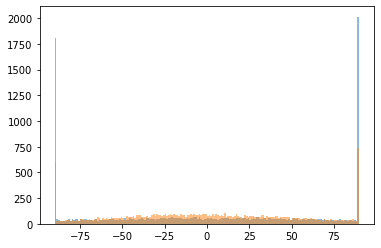

In [25]:
#plot_histogram("agent_angles", 120)
overlap_histogram("agent_angles", [10,120])
#plot_boxplot([25,50,75,100,125])

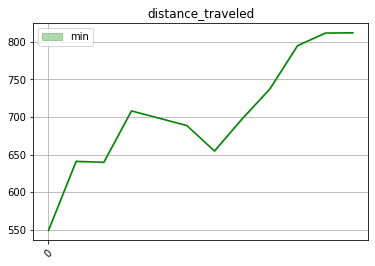

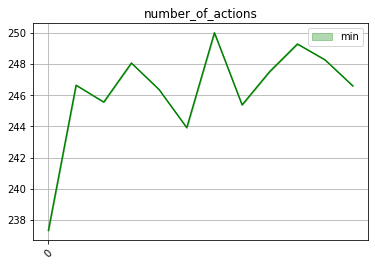

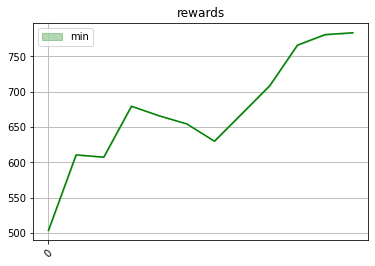

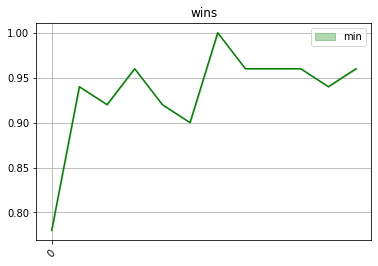

In [26]:
#plot_by_metric("commitment")
plot_by_metric("distance_traveled")
plot_by_metric("number_of_actions") #todo this metrics values are most likely wrong
plot_by_metric("rewards")
plot_by_metric("wins")
#plot_by_metric("avg_steps_per_episode")
#plot_by_metric("optimum_deviation")
#plot_complete_distribution("complete_distribution")

In [27]:
def combine_distri_trajectory(trajectory, distribution, index):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[index][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[index])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[index]))]
    d_ys = []   
    for coordinate in distribution[index]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination_{}.png".format(index),facecolor='white', dpi=300, transparent=False)
    plt.show()

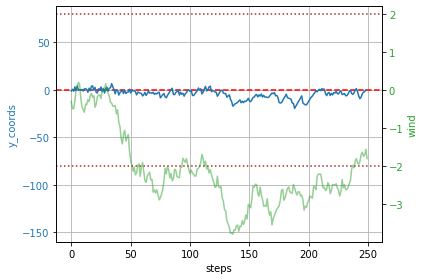

In [37]:
t="[[[4.9486833, -1.015596], [9.454272, 0.66069996], [14.239725, -1.2804587], [15.560524, 3.2402155], [18.811178, -0.5664496], [18.811178, 4.496406], [18.81118, -0.30037123], [23.787878, 0.33470747], [28.787857, 0.11367291], [33.712036, 0.5365245], [38.590073, -1.0749141], [42.798744, 1.0390589], [47.747406, 1.3820236], [52.72392, 0.5089081], [56.97676, -2.3698313], [59.149628, 1.8281204], [63.469578, -0.84158605], [63.66873, 4.065813], [68.6594, 4.175272], [71.525665, -0.075014934], [75.3663, 2.672757], [75.3663, -2.6994877], [80.36225, -3.0762007], [82.63242, 1.2450528], [87.59, 0.4616112], [91.70858, 3.0751119], [93.548874, -1.6128174], [97.62644, 1.3303543], [99.56781, -3.2436123], [102.07437, 1.2475622], [106.787094, 2.904117], [109.610886, -1.3173387], [113.273056, 1.9234297], [118.224106, 2.2999327], [119.89988, 6.661168], [123.842125, 3.1568055], [128.3114, 0.48680642], [131.13382, -4.0476966], [132.18304, 0.21400955], [137.18077, -0.15947494], [139.62187, -5.3698897], [142.8827, -2.5463111], [147.48576, -1.8755885], [150.87372, 0.38157773], [154.9025, -3.7413166], [157.88306, -0.78948975], [162.67267, -3.5698848], [167.03882, -2.377561], [171.84067, -2.1605742], [173.8631, 0.8103742], [178.38089, -3.1810975], [180.06671, -0.4437601], [184.8387, -1.0935279], [188.97607, -0.31546065], [193.95174, -2.05674], [198.86534, -5.167658], [198.86534, -2.1433923], [203.73549, -2.956821], [208.3716, -3.3589625], [213.00877, -3.5273774], [217.93797, -6.272893], [221.56578, -4.9709487], [222.87949, -2.5315347], [227.81805, -5.7453547], [230.4461, -3.754523], [230.4461, -0.9676181], [235.44405, -3.2751958], [239.70135, -3.0227795], [244.33374, -3.4961374], [247.56915, -2.3747137], [252.551, -4.578408], [255.91422, -3.5917196], [260.48633, -4.194561], [263.14154, -2.715625], [267.01462, -2.4461324], [271.0003, -8.302063], [273.315, -6.6090174], [276.09534, -5.064779], [279.37332, -3.688814], [284.13617, -7.2712545], [288.98145, -8.242], [291.01822, -5.6875987], [293.95157, -3.7385345], [296.42148, -1.7094387], [298.81326, 0.48576662], [302.13266, 1.8316929], [304.72665, -4.776287], [309.30057, -4.843158], [311.67712, -2.557623], [315.65067, -1.800218], [318.69263, -0.13507746], [322.76273, -5.344968], [322.76273, -2.3805726], [327.7627, -4.433651], [331.91876, -3.4541168], [336.7739, -6.5006065], [338.77716, -3.8204381], [342.88788, -2.78623], [345.29913, -0.38248703], [349.558, 0.13670169], [354.5285, -1.5241482], [358.3424, -0.3970984], [362.2462, -5.707505], [366.80496, -5.8748813], [369.5979, -3.99527], [373.02698, -2.617301], [376.22986, -0.8559948], [376.22986, 2.0816782], [381.22968, 0.034132056], [385.13794, 1.2333401], [388.46902, -4.1900587], [391.64316, -2.1326492], [392.82812, 0.7270883], [392.82812, 3.8530054], [396.92197, -1.0994092], [400.4745, 0.39856583], [400.4745, 3.2143013], [404.51398, 4.0619926], [407.98254, -1.7671062], [411.931, -1.0349542], [416.1309, -0.76330364], [421.0135, -2.2493243], [425.41217, -2.4207861], [430.04303, -6.574302], [432.16794, -4.5937786], [432.65402, -2.193866], [435.397, -0.551082], [439.29953, -0.2572573], [444.29953, -3.1801522], [448.5776, -3.7416933], [452.49347, -3.8112009], [457.47955, -7.626402], [458.67804, -6.2992353], [460.19336, -5.139088], [465.1268, -9.724867], [469.94983, -12.161514], [474.81955, -17.091404], [475.2493, -15.789434], [475.2493, -14.4795885], [478.2313, -14.044849], [480.30392, -13.047766], [480.30392, -11.76665], [481.08984, -10.413125], [486.06168, -13.476851], [486.06168, -11.915329], [490.57916, -13.310313], [491.21164, -11.790072], [495.2101, -12.075567], [496.9507, -10.784684], [497.043, -8.797192], [502.0346, -11.5649185], [506.47705, -12.369887], [507.038, -10.277946], [507.038, -7.818214], [511.15155, -7.534528], [513.0867, -5.405218], [517.0281, -4.819408], [522.0216, -7.28159], [523.0611, -5.1872463], [527.9007, -6.4896502], [528.4933, -4.289498], [533.4871, -7.4191546], [534.85284, -5.6707473], [539.71136, -7.5287995], [543.53424, -7.368906], [547.9316, -7.851334], [551.8472, -7.8998203], [552.80347, -6.2879267], [553.388, -4.527003], [554.46765, -3.1963663], [558.7299, -3.9641676], [560.81415, -2.7240531], [565.81116, -6.11406], [569.3775, -5.7498693], [574.2716, -7.819443], [578.6432, -13.29546], [582.9591, -13.663724], [587.0085, -13.366681], [587.61584, -11.019576], [587.61584, -8.922004], [587.61584, -6.7555866], [588.573, -4.565943], [593.48413, -8.098218], [598.07806, -8.678613], [602.5395, -9.0936775], [607.04034, -9.628342], [611.8569, -13.689188], [616.3874, -14.058573], [620.5356, -19.42514], [620.5356, -17.115477], [621.62854, -15.002276], [621.62854, -12.682953], [623.347, -10.667989], [623.347, -8.457793], [623.347, -6.2239776], [625.077, -13.80487], [629.5398, -14.710164], [634.06354, -15.639745], [638.03796, -15.69568], [638.7099, -13.69905], [638.9818, -11.593834], [640.705, -9.690248], [640.705, -7.5190277], [643.71063, -6.368188], [646.0213, -4.4697647], [648.8908, -2.9447906], [648.8908, -0.5660404], [653.81537, -1.9729494], [656.7332, -0.1267948], [660.73627, 0.6530876], [665.66656, -0.73107934], [667.882, 1.3630507], [672.5244, 0.6409444], [676.6336, 0.9308702], [681.1983, -3.7568488], [686.18066, -5.9492874], [686.5211, -3.4017992], [690.31274, -2.6450322], [695.2909, -5.8421626], [695.2909, -3.47778], [700.2369, -5.235437], [700.72766, -2.750663], [705.2637, -3.1557715], [708.11127, -1.5148759], [713.1042, -3.8275955], [717.54407, -4.173186], [717.73486, -1.9693937], [721.05963, -0.90590227], [725.8269, -4.770821], [729.86914, -4.405066], [733.7235, -3.71079], [738.71564, -6.054016], [742.95734, -6.0217505], [745.37213, -4.2126455], [745.37213, -1.6792461], [748.7261, -0.35293403], [753.5963, -3.5715847], [758.51526, -4.654887], [761.94574, -3.0662057], [762.5044, 0.022665456], [766.3184, 1.4502498], [771.11456, -1.8904406], [775.39325, -6.431415], [780.3151, -9.189142], [783.972, -7.4860864], [783.972, -4.123838], [787.351, -2.1845934], [791.9388, -1.9028537], [795.30164, 0.2351341], [799.7873, -3.780698]], [[4.8373127, 1.2328297], [8.33927, -2.1688418], [8.33927, 3.0990336], [8.33927, -1.9190267], [9.511479, 2.751499], [9.511479, -2.3418505], [9.511479, 2.3661728], [11.129055, -2.5877914], [14.912878, 0.18758231], [18.60218, 3.2112498], [22.452087, -0.55536807], [27.445036, -1.3096797], [29.683784, 2.4562073], [34.60708, 0.8637379], [39.35671, -1.1774579], [43.9787, -3.330558], [43.9787, 1.2506952], [48.93554, 1.4617091], [50.90534, -3.6009111], [50.90534, 0.7433903], [54.864517, -3.0582974], [58.85462, -0.6680306], [58.85462, 3.849073], [63.41987, 1.1074313], [65.77419, -4.158877], [65.77419, 0.1271807], [70.34118, -2.6439035], [72.897835, 0.9090953], [77.25447, -2.372481], [80.8711, -6.7838097], [80.8711, -2.5180914], [80.8711, 2.1045942], [83.68, -2.3589737], [88.58365, -3.6643286], [92.48342, -0.76668006], [97.032364, 1.1232591], [99.658424, 5.159268], [101.48156, 0.29738536], [104.06424, -4.27618], [104.06424, 0.7374658], [108.93117, -0.31554502], [113.57585, -1.8653858], [118.49781, -2.4223504], [123.43303, -1.1783046], [128.21436, -2.0567882], [128.21436, 3.2505147], [130.47035, -0.8754543], [135.47018, -0.71973413], [136.67838, 4.3448534], [136.67838, -0.34719074], [141.52513, 1.1473176], [144.00746, -3.0609195], [148.26384, -0.22061029], [152.93071, 1.9684153], [155.6781, -1.7306869], [160.63367, -1.9738481], [165.20575, -3.7738843], [166.66829, 1.239297], [170.90602, 4.2298574], [175.6476, 2.6424851], [177.19998, -2.1493654], [181.59184, 0.32298687], [186.55734, 0.868143], [190.8409, 3.4512465], [195.00272, 0.91793245], [197.2309, -3.3831098], [198.49826, 1.7386703], [200.13028, -2.6870072], [204.99869, -3.4760604], [205.12053, 1.9591402], [209.29086, -0.4868513], [213.43782, 2.9314358], [218.32413, 2.249213], [223.05983, 4.499539], [227.17099, 2.3958666], [230.67468, -0.5806666], [234.29518, -3.4489334], [238.85074, -0.62498903], [243.832, -0.41869444], [248.66843, 1.4868281], [248.97032, 6.9706306], [253.93245, 8.186499], [257.5018, 5.393524], [262.20602, 4.2690516], [265.9885, 1.4694021], [270.9829, 1.5609568], [273.10083, -2.5881472], [277.6905, -0.19017293], [282.02795, -2.0044262], [286.99387, -2.100453], [291.50174, 0.4108729], [294.46872, -3.4952784], [298.66458, -0.5427745], [301.84253, 3.6085129], [304.22598, -0.22830959], [308.45142, -2.3129294], [313.0401, 0.12001973], [317.74942, 2.325913], [322.13474, 0.3738851], [326.54285, 3.0915117], [331.46777, 2.7199242], [336.299, 1.8859607], [339.24176, -1.7760344], [343.2355, -4.3488], [347.23297, -1.0394647], [351.7652, 1.5337479], [355.94485, 4.7652183], [359.99188, 2.581091], [362.78967, 7.384181], [364.3418, 3.0891097], [368.03305, 0.30738553], [372.49765, -1.1917057], [372.99762, 4.6096253], [377.89316, 4.439308], [382.8718, 5.586421], [384.91092, 1.9232063], [389.85794, 3.757097], [394.40005, 6.9654417], [397.77994, 4.3660736], [397.77994, 0.31456295], [402.59305, -0.17412299], [406.66644, -2.20401], [408.67145, 2.9972825], [413.20535, 5.7840786], [414.0411, 1.6500245], [415.8311, 6.9763103], [419.5206, 4.106119], [419.5206, -0.16266891], [423.52084, 3.4676633], [427.15045, 7.479486], [431.47754, 5.665686], [436.36023, 5.1528964], [437.5033, 0.9221028], [442.49216, 0.974025], [447.37466, 0.39044034], [452.37354, 0.7079031], [456.45142, -1.80247], [460.6061, 1.30142], [460.6061, -3.3933864], [465.15, -0.95527464], [468.63248, 3.1661067], [473.58112, 3.054989], [478.5324, 4.323281], [483.24118, 3.2223823], [485.8449, -0.277256], [490.608, -0.80704945], [495.0865, 2.7275414], [498.84735, 0.6147073], [503.84494, 1.8997225], [508.82565, 2.948965], [513.3875, 2.346173], [517.8197, 6.2846603], [517.8197, 2.7651591], [522.7979, 3.576379], [527.5919, 3.5804331], [530.98926, 1.3514068], [535.8246, 1.3713791], [540.0688, 5.264052], [544.4354, 8.892512], [546.5583, 5.61059], [550.9794, 4.4374933], [553.1357, 1.2569911], [558.13513, 2.688407], [560.2247, -0.51325876], [562.5403, 5.1250906], [564.93, 1.6896843], [569.86035, 2.1777415], [572.91266, -0.7685676], [575.04425, -4.258623], [577.9063, 0.9695252], [582.87726, 2.6090853], [582.87726, -1.2287172], [582.87726, 4.7309294], [587.56305, 3.806393], [592.06726, 6.6221604], [596.8879, 6.1714897], [598.5571, 2.2456553], [603.55707, 3.3590155], [608.4738, 3.7335064], [612.6413, 7.8479548], [613.4292, 4.2225895], [618.07355, 3.567639], [622.9632, 5.771268], [622.9632, 2.0572255], [626.5625, 7.2466955], [631.5217, 8.316063], [636.02466, 12.296868], [636.64636, 9.254294], [641.6408, 10.810577], [646.0712, 10.176239], [647.5867, 7.132289], [652.44415, 7.6078515], [656.35144, 6.0082707], [660.4585, 10.381281], [664.608, 8.952621], [668.69727, 7.4107575], [672.1578, 5.0102863], [675.36255, 9.877583], [677.85034, 6.6305804], [681.271, 4.211716], [684.82495, 8.791227], [689.5259, 11.543932], [694.5245, 12.31195], [694.5245, 8.145365], [698.40546, 5.938965], [702.9638, 9.194117], [705.3114, 6.0082774], [709.9589, 5.5044503], [713.73334, 3.705756], [718.1067, 3.1078916], [719.83594, 0.27876142], [723.8981, -0.8343316], [728.03033, 4.1062655], [732.96405, 7.346968], [737.96, 10.1961565], [742.05457, 10.006004], [746.567, 15.060731], [747.3444, 12.875203], [747.3444, 10.872498], [748.9, 9.171084], [753.81165, 11.326916], [758.4516, 12.536301], [762.66113, 13.202742], [764.58374, 11.744152], [765.22095, 10.032896], [770.02966, 14.343518], [775.02875, 17.487534], [779.814, 22.101446], [779.814, 20.205194], [780.3562, 18.37425], [784.1436, 24.793402], [786.0436, 23.320187], [791.00006, 25.822086], [792.1482, 24.244959], [794.4277, 23.167713], [794.4277, 21.52865], [796.7761, 20.713648], [798.83136, 19.782251], [803.5954, 21.916687], [808.29614, 23.99649], [810.07465, 23.127087], [810.07465, 21.680223], [815.02045, 24.374086], [815.02045, 22.975906], [816.9832, 22.114595], [821.9472, 26.387217], [826.85815, 29.10328], [828.6298, 27.952175], [828.6298, 26.347769], [828.6298, 24.833363]], [[4.978519, -0.61301434], [9.946154, -0.338159], [14.021057, 2.1740582], [15.84548, -2.9047148], [15.84548, 1.6850128], [15.880627, -3.6524506], [15.880627, 0.9870701], [18.246262, 4.8813295], [18.246262, -0.22833669], [22.063635, 3.0710611], [22.063637, -1.815607], [24.41991, 2.7033622], [27.458092, -1.2542411], [30.835989, 2.350332], [32.485954, -2.5966187], [37.057518, -0.641643], [41.837894, 0.8000663], [46.775795, 0.065531895], [49.43137, 4.223838], [51.28182, -0.3997598], [56.000416, 1.1686475], [60.68922, -0.5292934], [63.146996, 3.6854126], [65.70873, -0.8975905], [70.313805, 1.1768457], [74.89897, -0.52538717], [79.628685, 1.2525419], [84.384796, -0.22191721], [88.53919, 2.5028138], [92.820854, -0.19305478], [96.650276, -3.571833], [101.11091, -1.4069545], [105.66079, 0.59372765], [106.75026, -4.167081], [111.106544, -1.3968772], [116.03807, -2.1143851], [120.07857, 1.0169152], [125.05729, 0.58624643], [130.05667, 0.23911364], [134.8891, 1.2762294], [139.52896, -0.8744317], [143.97224, -3.606894], [144.83952, 0.7997998], [149.39247, -1.8595663], [154.14622, -1.0528334], [158.3036, 0.872089], [163.30121, 0.034874003], [167.79515, -2.939371], [172.57072, -4.9712873], [173.78702, -0.803201], [178.78694, -1.3402066], [183.41974, -3.3928015], [186.16992, 0.7088042], [189.82358, -2.6292994], [194.71922, -1.7287933], [199.48265, -3.4513788], [202.91689, 0.17502296], [207.26006, -2.11549], [212.2316, -1.1703588], [215.9613, 2.406575], [219.92365, -0.5276749], [224.54927, -2.442392], [224.58873, 2.532229], [227.22656, -1.953897], [227.22656, 2.599961], [232.2031, 2.5977929], [237.04718, 1.0884387], [242.03127, 0.3165215], [247.03127, 0.053679906], [252.02742, -0.46190795], [256.77435, -2.7753265], [261.05588, -0.97195494], [262.80817, 2.8003383], [264.10944, -3.1486065], [269.10852, -4.3086762], [271.482, -1.2694108], [271.8408, 2.3076682], [275.57782, 4.5811524], [280.35883, 2.2869372], [284.4136, -1.4891009], [286.88977, 1.9256287], [291.6364, -0.3936879], [294.38623, 2.8911657], [299.3813, 2.1829817], [304.30994, 0.68724024], [307.95273, 3.3037035], [312.89606, 1.4933345], [317.89194, -0.06024624], [322.0501, 1.1826774], [326.3025, -3.094921], [331.10983, -3.290992], [334.34695, -1.0012635], [339.29037, -3.0917094], [342.64233, -0.56032157], [345.0441, -6.1368666], [349.54288, -5.2137938], [351.86813, -1.9611057], [356.12537, -0.57186025], [357.07956, 3.1322258], [360.9366, -1.2232956], [365.76413, -1.2751046], [370.69092, -1.9967225], [375.0927, -1.3329223], [375.29657, 2.0751038], [380.29654, 0.5437654], [385.29465, -1.0654763], [386.88715, 2.1121259], [391.56927, -1.0370706], [394.51974, 1.5736214], [399.42023, 0.8759795], [403.30762, 2.4306116], [408.1628, 1.9925157], [413.0845, -0.5366967], [416.88165, 0.96850085], [421.8727, -0.3943017], [426.05826, -4.884239], [430.98978, -5.902619], [434.78406, -4.381], [435.23206, -1.042615], [439.48795, 0.19664392], [444.48053, -1.4877537], [449.1165, -1.2749312], [451.17456, 1.5092548], [455.1065, -3.4235575], [460.10608, -5.4651747], [460.37637, -2.3336174], [465.31055, -3.3578138], [469.39746, -2.4424727], [474.24908, -3.4376442], [479.03952, -4.3532624], [484.02628, -6.374459], [485.28, -3.896356], [485.31113, -1.3046619], [488.57288, -7.622214], [492.9514, -7.644993], [496.53186, -6.6115985], [498.0561, -4.44109], [498.0561, -1.7472959], [500.9775, 0.07470075], [503.15387, 2.4774458], [508.1208, 1.1757045], [512.8471, 1.1890743], [517.60034, 1.0696166], [522.4981, -1.422543], [526.3075, 0.46376526], [530.92096, -2.8326879], [535.2044, -1.5792204], [539.42773, -0.025805397], [544.38104, -0.5445662], [549.03296, 0.11195418], [553.8648, 0.31716052], [558.7993, 0.20559238], [562.90607, 2.113999], [567.86597, 1.7782409], [568.0756, 5.8157396], [571.5667, 1.3255614], [572.62897, 5.513978], [577.6281, 4.4968686], [581.485, 0.60816634], [585.90186, -2.4843879], [589.1229, 0.6527065], [591.0438, -4.806937], [591.0438, -0.44580558], [596.01807, -1.573341], [597.33575, 2.7327456], [598.32404, 7.2443595], [598.32404, 1.7520251], [602.75995, 3.464155], [604.2179, -2.0371141], [608.5091, -0.40262717], [613.32587, 0.16197635], [618.3038, 0.03276259], [618.3038, 4.6485686], [622.687, 1.8537407], [627.1426, -0.7676897], [631.83325, -2.9814816], [635.61475, -6.790076], [639.77325, -4.586047], [643.3384, -1.7882612], [646.2558, 1.4927675], [649.9773, -2.7909815], [654.31805, -1.3619314], [659.2177, -1.4419647], [664.0401, -3.9351957], [664.9371, -0.1317383], [669.63367, 0.3258207], [674.22974, -2.7746959], [677.0788, 0.25230542], [679.39594, 3.4027545], [682.63776, 6.0886803], [687.28784, 3.0098684], [691.6934, 4.250589], [696.5508, 4.253355], [701.5107, 3.501041], [703.3712, -2.7395375], [708.2027, -5.770556], [708.2027, -2.6135037], [713.1927, -4.780295], [718.1198, -5.6637726], [723.11316, -7.1743207], [723.11316, -3.9544423], [728.1116, -5.7708044], [732.98236, -6.342833], [734.4275, -3.2265925], [735.21063, 0.20236222], [738.9413, 2.0974739], [742.8614, -2.06997], [745.7365, 0.73181784], [750.14185, 1.8284469], [753.6636, 3.84092], [756.93066, 5.8007474], [759.4689, -0.25620964], [762.3188, 2.276988], [766.5602, 3.5421476], [771.3631, 3.2736993], [774.35004, -2.3692439], [779.1479, -2.3355165], [781.33606, 0.7815644], [786.3012, -0.1315387], [790.8508, 0.23737969], [795.761, -0.60607946], [800.7475, -2.8252578], [805.3206, -2.7061908], [809.87305, -2.6011157], [814.7501, -3.56735], [817.111, -1.4518889], [819.7765, 0.49532568], [822.84174, -5.907308], [825.94, -4.458788], [827.2648, -2.3123777], [832.1271, -3.7060337], [836.5822, -8.599608], [841.2715, -13.211589], [843.64453, -11.5042305], [848.638, -13.884865], [850.22125, -11.627375], [852.2366, -9.161977], [854.36755, -6.983067], [858.6558, -6.708502], [862.3935, -5.5351396], [862.3935, -2.7020404], [867.113, -3.0470595], [872.09937, -5.4012475], [877.08826, -7.057501], [881.3574, -6.3191843], [885.9891, -6.3042], [888.461, -3.6975384], [889.4016, -0.49833736], [894.3971, -1.9549056], [899.2929, -2.6819012]], [[4.9599857, 0.9105755], [9.537096, 3.3448603], [13.572036, 0.9207495], [13.575006, -3.539441], [13.575006, 1.8433123], [17.031126, -1.5963848], [18.861568, 3.4476082], [18.861568, -1.539555], [23.635582, 0.18174228], [28.122719, -1.7335365], [28.122719, 3.449144], [28.122719, -1.4253207], [28.122719, 3.8396864], [29.582087, -0.7008409], [29.582087, 4.6605215], [31.549582, 0.32702503], [35.68432, -1.9162899], [35.68432, 3.3782434], [38.644352, -0.39637172], [43.003666, 2.397726], [43.003666, -2.038699], [43.58476, 3.7141085], [48.562943, 4.388516], [53.262913, 3.612392], [57.977608, 2.7360601], [62.74685, 2.1101208], [67.24764, 0.692467], [72.078545, 2.7131042], [76.69223, 5.338971], [80.94417, 3.5185115], [81.48846, -0.6301675], [82.69356, 5.2198763], [86.76997, 3.088475], [90.7083, 0.6042409], [90.7083, -3.8388603], [95.28499, -1.1563637], [95.284996, 4.406791], [100.282616, 4.734501], [104.98575, 3.4876404], [106.10632, -0.77110344], [111.038635, 0.7335164], [113.93062, 5.125643], [114.92506, 0.78291506], [119.92063, 1.1695437], [124.79506, 0.6001146], [129.79218, 1.0975488], [134.30182, -0.22981597], [138.5806, 3.124913], [142.48389, 0.64685875], [147.43571, 1.7845035], [150.64163, -1.5562148], [154.47081, 2.0049484], [159.39346, 3.502631], [164.17268, 5.470283], [166.2756, 1.4260075], [168.97903, -2.3698716], [168.97903, 3.0305042], [173.67789, 1.6814542], [178.65875, 1.9168253], [183.55597, 1.3926543], [187.53093, 4.9895267], [189.28903, 0.699435], [190.22963, -3.7572496], [191.72183, 1.5857757], [196.71361, 1.7932892], [201.28508, 0.24229954], [203.5079, 5.0601926], [206.3339, 1.2282054], [211.30478, 1.1742183], [215.41235, -1.0522679], [220.18504, 0.98969674], [222.18033, 6.283284], [223.12328, 2.173608], [228.0868, 2.1650772], [230.73074, 7.004635], [235.62912, 6.5977707], [239.83936, 10.05107], [244.7917, 9.873333], [246.91418, 5.5993514], [249.5768, 1.6871144], [254.41867, 3.270341], [254.41867, -1.0739254], [254.88036, 4.60836], [259.61923, 3.5365586], [263.91095, 6.5195727], [263.91095, 1.8686132], [268.80942, 0.9373407], [268.80942, -3.975493], [273.43518, -1.8822513], [278.42838, -1.8783897], [281.20255, 2.480134], [283.77155, -1.39502], [288.0234, 1.7107288], [292.02554, -0.86703366], [293.49872, 4.2290983], [298.44986, 3.9045045], [302.54343, 7.1567907], [302.63623, 2.5666678], [307.53275, 3.8866746], [312.51306, 3.8504698], [313.12936, -0.7615175], [316.73563, -3.6758544], [318.40234, 1.6343709], [322.3359, 5.229076], [325.76724, 1.9463077], [330.76666, 2.3365433], [334.94968, 5.7491198], [337.62106, 2.2323043], [342.4397, 1.5949646], [347.33722, 1.3736115], [351.04312, 5.963092], [353.50015, 2.823882], [358.4998, 4.200555], [363.4998, 5.7672563], [368.44424, 7.8926415], [373.2783, 8.0402565], [378.1839, 8.541449], [378.81158, 5.0386586], [382.7993, 3.311139], [387.2353, 6.8710346], [387.2353, 3.0069487], [389.62915, -0.24251278], [392.4604, 4.9541326], [396.70172, 8.8354435], [401.31094, 8.225577], [405.04956, 5.862658], [409.29742, 4.15237], [413.14136, 1.8939433], [418.1047, 3.3123522], [422.7034, 5.9248085], [425.0191, 2.213021], [428.925, 5.9214225], [432.30228, 3.0920682], [437.07028, 2.7477517], [441.94574, 5.0816], [445.68744, 3.0275228], [450.65393, 3.698929], [455.62427, 5.6290574], [460.31235, 5.5815005], [464.72946, 5.2485566], [469.15146, 5.0683], [474.04507, 6.528922], [478.44385, 6.6335034], [482.0488, 5.745845], [486.635, 6.335818], [490.04572, 5.378508], [495.0453, 8.165931], [496.41882, 6.135855], [500.63013, 6.245631], [503.09665, 4.484333], [507.9013, 8.272123], [512.0394, 7.6155734], [516.22266, 6.906146], [516.6156, 4.292729], [520.2265, 3.0747082], [524.28925, 2.409515], [528.5243, 2.1288443], [532.8746, 1.8538029], [537.8695, 4.482817], [542.8216, 6.4009185], [547.81824, 9.1765785], [551.32336, 8.193981], [553.14197, 6.1216536], [558.116, 9.234241], [560.8603, 7.8433228], [565.7564, 11.721788], [566.4729, 9.660419], [566.4729, 7.55888], [566.6657, 5.52501], [571.4618, 7.2206016], [576.0984, 8.910826], [576.0984, 7.3757453], [581.01135, 9.969823], [581.01135, 8.457301], [586.01135, 11.859933], [587.62537, 10.429974], [590.0923, 9.340437], [592.7653, 8.645202], [595.5885, 8.034369], [600.1274, 9.517422], [601.8313, 8.429693], [606.0816, 9.195933], [608.95886, 8.413209], [609.0675, 6.701955], [611.80615, 6.0288997], [616.6595, 10.803481], [618.76556, 9.831072], [621.07556, 8.713381], [624.845, 8.624075], [629.7687, 11.134182], [633.5527, 11.196185], [636.7981, 10.704104], [641.7907, 14.264677], [645.5634, 21.100632], [650.27264, 23.207478], [650.27264, 21.838678], [651.4036, 20.57923], [651.4036, 19.059702], [655.61957, 19.910866], [660.5793, 22.79993], [662.01526, 21.417381], [663.7686, 20.300285], [664.9128, 18.91292], [664.9128, 17.608473], [664.9128, 16.423962], [669.1663, 17.443115], [673.99066, 19.586489], [678.8714, 22.031124], [683.87036, 25.46698], [685.8459, 24.381487], [685.8459, 22.960527], [690.834, 26.127514], [692.24304, 24.91131], [693.7845, 23.764124], [693.97986, 22.469809], [698.9688, 26.015642], [701.2085, 25.20099], [702.99915, 24.430758], [702.99915, 23.065712], [705.2559, 21.875273], [707.38763, 20.470789], [711.9537, 21.611345], [715.3335, 21.058208], [719.3787, 21.328588], [724.1029, 22.792927], [727.7403, 22.472815], [728.82, 20.787151], [728.82, 18.690363], [731.33765, 17.505302], [735.2021, 17.660316], [736.5259, 16.005098], [741.2955, 17.794508], [745.43726, 18.132427], [749.6744, 18.710182], [754.2084, 19.58484], [757.65576, 18.884512], [761.5627, 18.824537], [765.19244, 18.70789], [770.16174, 21.289713], [770.16174, 19.735401], [774.18317, 20.208359], [778.76013, 21.78177], [782.3992, 21.62999], [785.08496, 20.73268], [785.08496, 18.967413], [786.9657, 17.606258], [790.78564, 24.264763], [795.265, 25.415258], [799.9149, 27.077682], [804.1451, 27.965322]], [[3.3928866, 3.7272716], [3.3928869, -1.1133183], [7.184481, 2.1065989], [11.746381, -0.39118713], [13.8133545, 3.409592], [18.486673, 0.86999494], [19.057817, -5.0441704], [19.05782, -1.0701586], [24.01766, -1.8129998], [24.01766, 1.9398832], [25.205164, -4.6187406], [25.205164, -1.5273194], [29.581398, -0.81022334], [32.856888, 1.2678899], [36.228123, -4.1801476], [36.228123, -1.1098965], [38.152767, 1.4545392], [41.728634, -4.0955796], [41.728634, -1.2084529], [46.327576, -5.099376], [47.092815, -2.3556793], [49.490974, -0.18005188], [52.71099, 1.2948697], [57.694523, -1.2897271], [61.075176, 0.1392388], [65.82321, -0.3976203], [67.636536, 2.168724], [72.40537, -1.500666], [72.76629, 1.129039], [77.71891, -2.0478022], [82.604576, -3.4126444], [82.604576, -0.80919504], [87.282616, -1.405319], [89.37574, 0.6210697], [93.872955, -3.8222122], [98.78208, -5.1173086], [98.78208, -2.6143134], [103.712364, -5.908616], [104.369316, -3.2417984], [106.48637, -1.1239377], [109.95294, 0.3453034], [114.41427, 0.6880626], [119.25984, -2.3896487], [120.3262, 0.62887025], [125.179695, 0.060789548], [129.93977, -3.2368152], [131.71219, -0.4684614], [135.84737, 0.3520945], [140.80858, -1.0686307], [145.80614, -2.8979108], [147.96164, -0.48387003], [151.7674, -6.021133], [153.84294, -3.9548225], [158.39755, -4.625403], [159.07906, -2.5634484], [163.63602, -3.4780724], [166.667, -2.300209], [166.667, -0.22968905], [171.27347, -1.238113], [172.84358, 0.2983801], [177.78517, -1.8993974], [181.4276, -1.4605196], [185.8132, -2.0005367], [190.62234, -6.290572], [193.07326, -4.911836], [193.07326, -2.7737086], [193.07326, -0.48576677], [196.64346, -6.6904197], [196.64346, -4.361218], [201.5633, -6.2026725], [205.15076, -5.6720686], [209.31258, -5.8859267], [212.1003, -4.6205225], [216.22765, -4.7645965], [220.742, -5.4718456], [224.39366, -4.755452], [228.68379, -4.5831757], [233.58723, -6.045354], [235.86008, -4.2133183], [240.2441, -4.802612], [245.24333, -7.949377], [245.24333, -6.230747], [245.24333, -4.283264], [246.6394, -2.5662248], [251.6293, -6.168764], [251.7837, -4.279822], [253.7993, -2.973068], [254.94952, -1.4270695], [258.82257, -1.5175029], [262.47943, -1.2110243], [267.39682, -3.2864141], [271.6844, -3.677497], [271.6844, -1.4766761], [271.6844, 0.82977146], [274.84213, 1.825875], [278.61505, 2.0585601], [283.61462, -0.87318736], [288.59955, -3.9262698], [290.05914, -1.8768876], [294.32706, -1.8700329], [297.97745, -1.1566439], [302.9285, -3.1530664], [307.6766, -7.5653386], [308.58142, -5.433245], [311.63513, -4.062868], [311.63513, -1.6522926], [316.51968, -3.2357259], [316.51968, -0.59529454], [320.04993, 0.50632006], [324.69812, 0.020239152], [328.98438, 0.25487208], [333.8751, -0.9651539], [338.5387, -1.3627986], [338.5387, 1.5760341], [343.04395, -2.8174236], [346.76038, -1.6653556], [351.15656, -1.5179596], [355.51724, -1.2170262], [359.70352, -0.8525079], [363.54446, 0.13781846], [368.52246, -1.5612481], [371.59756, 0.4485268], [376.59708, -1.6662179], [376.59708, 1.1212915], [381.54517, -1.7511277], [386.10376, -2.0826902], [390.97217, -5.5815825], [395.9721, -7.7907715], [399.17578, -6.068336], [401.83084, -4.1467547], [405.66037, -3.1914623], [409.2819, -2.0772753], [412.7101, -0.76749045], [417.19336, -5.038666], [420.70502, -3.4779847], [420.70502, -0.17933714], [425.63956, -0.8618539], [428.62122, -6.490265], [428.62122, -3.08588], [428.62122, 0.36534196], [433.20847, 0.71117663], [437.2428, 2.2503037], [441.16348, 3.9763389], [444.53098, -1.3842874], [447.24582, -7.2713084], [451.954, -7.1011643], [454.54358, -4.2292128], [459.48734, -4.7803836], [463.95816, -3.696663], [467.27466, -0.89639634], [472.21204, -1.0448244], [474.6156, 2.2971783], [476.05347, 6.093812], [479.0369, 0.94533885], [483.8828, 1.2645137], [488.83365, -0.033821724], [493.81528, -1.2557561], [498.3721, 0.084944874], [499.70792, 4.6227827], [504.69525, 4.7880993], [509.62286, 3.782105], [513.8363, 6.4921093], [517.6963, 3.3568797], [517.6963, -1.3541102], [519.6777, 3.7249103], [520.78394, -0.63572454], [525.5328, 1.283204], [528.81445, 5.3461757], [529.48755, 0.9400048], [533.8809, 3.822583], [538.8364, 4.122265], [541.8294, 1.00401], [546.6328, 0.07576505], [551.5527, 1.0441887], [556.4634, 1.8881514], [558.83026, -2.4637067], [563.32904, -0.42561716], [567.825, 1.432288], [571.3208, 4.7457943], [576.31586, 4.2172756], [579.1178, -0.03646496], [583.3341, 2.4028811], [588.2475, 3.2694464], [593.24396, 3.491736], [593.24396, 8.472972], [598.08496, 9.435987], [600.85394, 5.1729016], [605.7897, 4.3609967], [610.51385, 2.270357], [612.9749, -2.3505683], [615.39276, 1.7657909], [620.3499, 0.60922337], [623.7931, 3.8884883], [624.81494, 8.407506], [624.9971, 2.924925], [629.87213, 1.1841061], [634.425, -1.3239948], [639.4001, -1.2130034], [644.4001, -1.6427369], [647.64465, 1.5166336], [652.5324, 2.0446572], [657.48334, 2.094044], [662.46967, 1.6728184], [666.37573, 3.701002], [671.35693, 2.223585], [675.43427, -1.795323], [680.319, -2.065494], [684.9662, -1.6220707], [687.66876, -7.150061], [689.3329, -3.8282373], [693.0893, -1.9552381], [698.0877, -3.6622894], [703.0703, -4.977412], [703.87885, -1.6398914], [708.0268, -6.297063], [712.49786, -5.957899], [717.31964, -6.3793225], [719.7321, -3.5485928], [724.6327, -4.2621536], [729.6087, -5.7496815], [729.6087, -2.90053], [731.4891, -0.6782738], [735.2605, 0.29773307], [740.0969, -3.2163095], [745.0962, -5.549141], [749.7795, -6.0105667], [752.864, -4.238616], [753.63324, -1.4336526], [758.4348, -2.0959377], [762.38556, -0.8987499], [767.3039, -3.571778], [770.97504, -2.0592778], [772.87427, 0.7273155], [774.9627, 3.6302168], [779.6736, 0.26242185], [782.9793, 2.3946197], [787.3339, -1.6293902], [790.37585, 1.0131857], [794.37537, 2.736199], [799.3452, 2.0184011], [804.17725, 2.1090353], [804.2177, -4.119118], [808.2431, -2.4158783], [808.2431, 1.4342376], [812.6661, 2.5076244], [817.6527, 1.6050806], [822.2754, -1.8147732], [826.5739, -0.70555204], [830.90295, 0.39156443], [834.7487, -4.1853013]], [[3.7854874, 3.3914552], [7.3032556, 0.2564506], [12.00327, -0.8872477], [12.003271, 4.580155], [12.003271, 0.03327493], [16.886866, 1.7208647], [20.66756, -1.013076], [24.722391, 2.7449296], [27.348698, -0.4038714], [31.535675, 3.4796507], [31.535675, -0.33390716], [34.681248, 4.848202], [38.31293, 2.7718627], [40.39593, -0.62331027], [43.363403, 4.4405375], [48.350155, 5.909361], [52.01955, 3.8422418], [52.444164, 0.52155715], [57.240177, 3.4580917], [58.124268, -0.23249045], [62.87902, -0.58797526], [66.98285, 3.4119601], [68.25484, -0.27587795], [71.43213, 4.5064473], [72.976974, 0.6873722], [77.189064, -1.1601247], [78.01652, 4.8169694], [82.87503, 4.5634], [85.32109, 1.151411], [90.04988, 0.3091918], [93.82185, 4.5154843], [94.90808, 0.5194133], [99.4706, 3.376239], [101.34334, -0.30320048], [105.49105, 3.2386832], [108.9085, 0.25410992], [113.89486, 1.3659749], [117.49883, 5.592552], [120.56774, 2.4206352], [123.233345, -1.031652], [126.81617, 3.0797122], [131.19244, 1.106751], [135.8234, 3.5067234], [138.77863, 8.022986], [143.4222, 6.6573873], [147.23314, 10.268754], [152.17609, 11.432169], [153.44247, 7.2359295], [158.14035, 6.2894087], [158.49545, 1.9636621], [162.853, 0.28914326], [167.84857, 0.8836014], [171.23737, 5.371773], [174.68228, 2.4276402], [179.6814, 3.387648], [183.60014, 1.0809927], [187.16855, 5.52664], [190.68411, 2.6452315], [195.64233, 3.9719708], [199.99768, 2.1295378], [204.8425, 4.09928], [208.27043, 0.9709593], [213.24892, 1.8240112], [216.11821, 5.980508], [220.43214, 3.5677261], [225.12668, 5.2079964], [227.37239, 9.577183], [229.21117, 4.9677124], [231.66252, 0.60777235], [236.57396, -0.3689429], [241.55084, 0.034116965], [242.54002, 4.8888855], [246.8575, 2.2647564], [251.84528, 2.6097183], [256.71585, 3.8822095], [261.40817, 5.6529627], [266.2081, 4.0667715], [271.15753, 3.1220117], [274.941, -0.35634324], [279.0024, -3.6746423], [283.89694, -3.1817915], [288.49286, -1.6689168], [291.22046, 2.1176133], [295.1599, -1.1844554], [299.74844, 0.6466888], [303.81952, 3.4370954], [308.48627, 1.4150224], [313.47598, 0.9687965], [318.08792, -1.023439], [322.72333, 0.76611775], [324.70337, -3.901775], [328.02112, -0.43073785], [332.54193, 1.4352295], [332.8119, 6.359851], [336.45117, 2.8949747], [340.23383, -0.47351], [341.84766, 3.9068582], [346.6089, 1.922067], [351.31396, -0.39007437], [356.31357, -0.83792454], [361.09546, 0.08720734], [365.50067, -2.6277866], [367.6715, 1.708613], [367.6715, -3.4802215], [369.45242, 0.9550409], [374.44455, 1.2234926], [374.44455, 6.192954], [374.44455, 1.0155834], [379.23553, 2.1733246], [384.1534, 0.83255166], [389.05255, 1.2667416], [390.32272, -3.9485404], [390.32272, 0.6917854], [390.32272, 5.4420924], [394.14798, 2.2003138], [397.9867, -0.98775756], [402.81592, -2.4746835], [404.0643, 2.085732], [409.0593, 2.0066311], [412.12317, -2.0242841], [414.82397, 1.8218291], [419.11243, -1.3194733], [420.69525, 2.8654444], [425.62723, 3.1965046], [428.60562, -1.4901127], [431.1982, 2.2485058], [434.64526, -2.0679536], [439.14798, -4.780841], [443.90036, -3.9149938], [448.8409, -5.4652696], [450.87878, -1.8848654], [455.57947, -1.1135343], [459.1872, 1.3114749], [463.85315, -1.4453188], [463.97156, 2.3632753], [468.96094, 0.822572], [473.7029, 1.0268747], [475.85828, 4.3235564], [480.74197, 4.1866827], [485.6162, 1.82776], [487.81613, 5.1133766], [492.38406, 1.9127905], [497.1127, -0.9192862], [502.07983, -1.4688492], [503.33856, 2.5110502], [507.7454, 4.282566], [509.9384, -0.50603193], [512.33185, 3.2567613], [515.8035, 6.0452743], [520.58514, 3.9468095], [524.7987, 0.54237264], [529.7191, 0.33372572], [532.81384, 3.246913], [537.5107, 0.91550994], [542.4968, 0.07254792], [545.39233, 3.4289057], [549.43445, -0.1825814], [554.0867, -2.5719094], [558.09357, -0.4665925], [563.0812, -0.9431095], [568.0631, -2.231115], [569.71826, 1.6662949], [574.47845, 2.3310058], [578.53314, -1.3068665], [583.02277, 0.117235124], [587.83105, 0.54699874], [592.40857, 1.7391214], [597.34955, 0.051339097], [602.1698, 0.26621208], [602.1698, 4.1391535], [607.13464, 2.433702], [609.98914, -3.0164673], [609.98914, 0.56806606], [613.91473, 2.267775], [618.4883, -1.2161728], [623.3369, -1.4271091], [627.8677, -0.7871858], [632.84674, -2.6554284], [632.84674, 1.1263568], [637.7863, -0.8094378], [642.6008, -0.45933], [645.95776, 2.4328012], [650.0221, -1.4214944], [654.61334, -0.49551308], [656.1835, 3.409492], [661.0986, 3.3139687], [665.8618, 0.6309615], [669.45233, -4.155668], [672.5294, -1.4192096], [677.38684, -1.4113733], [681.3156, 0.5807435], [685.99274, 1.3040981], [690.51447, -2.002517], [693.0821, 1.3102032], [697.8568, -1.0382321], [702.8511, -1.8684423], [707.78516, -3.3056316], [712.57947, -2.5158885], [717.57794, -3.3441422], [721.4458, -0.9617168], [724.52856, 2.051342], [729.4961, 0.8550125], [733.31714, 3.2000415], [736.3797, 5.9974723], [741.1699, 3.2750843], [746.167, 2.013171], [749.85425, -2.761918], [749.85425, 0.6058674], [752.7245, 3.2232563], [757.3899, -0.20672457], [761.7395, -4.1837416], [764.96686, -1.9270451], [769.96423, -3.9370995], [772.5987, -1.3613735], [777.5957, -2.787349], [782.164, -2.264766], [787.0105, -2.551487], [787.0105, 1.179089], [789.7706, 4.191132], [793.75415, 6.0449595], [797.99304, 2.0303135], [802.9218, 1.6343603], [807.5762, 2.30571], [810.21924, -3.102114], [810.21924, 0.73859644], [813.95544, 3.0562408], [818.9528, 1.867189], [823.47516, -1.232211], [828.3674, -3.2299862], [828.3674, 0.9141512], [832.46625, 2.9434266], [837.1196, 4.0058994], [841.7574, 1.3233169], [846.6914, 1.2357917], [851.5841, -0.74336886], [856.5331, -2.304057], [861.1002, -5.160239], [865.8468, -4.923995], [866.0025, -1.0791838], [866.0025, 2.9670637], [868.41315, -2.507647], [871.7345, 0.34695348], [875.5042, 2.3789794], [878.359, 5.072229], [883.069, 2.0584316], [885.8039, -3.648037], [890.48413, -3.3928099], [893.24554, -0.5635416], [897.65125, 0.614341], [901.00525, -4.3582435]], [[4.803572, 1.1846049], [8.896502, 3.6443238], [8.8965025, -1.7439982], [13.782066, -1.1958882], [18.759737, -2.1323059], [18.759737, 2.3991756], [20.555485, -2.3834798], [21.33636, 2.175705], [21.33636, -2.986668], [21.33636, 2.0584452], [21.33636, -2.689857], [21.33636, 2.5881777], [24.5832, -0.945708], [29.214622, 1.246072], [34.127697, 2.4032886], [39.120544, 2.565668], [41.57839, -1.1687745], [44.621464, 3.41901], [44.639393, -0.9194626], [44.639393, 4.6098833], [44.639393, 0.31051], [47.192818, -3.097458], [51.354935, 0.6904952], [55.33276, -1.30546], [60.31594, 0.05251652], [65.31025, 0.73986757], [69.78604, 4.072304], [74.14245, 2.8353631], [78.89572, 2.5009875], [83.07691, 1.0987822], [87.015594, -0.6923158], [91.6509, 2.5322907], [94.56232, -0.47599465], [97.724594, 4.6231866], [97.724594, 0.9266725], [99.73608, 7.034807], [104.6337, 7.480642], [109.1224, 6.68286], [110.46512, 3.4816415], [114.74988, 2.6129086], [119.47861, 2.56773], [119.47861, -0.82588977], [124.45197, 1.4739777], [129.23714, 1.7436286], [132.9821, 6.7295322], [135.07497, 3.6254842], [137.59691, 0.88941205], [141.66293, 5.3797884], [146.29027, 5.448317], [149.68231, 3.7799032], [154.62672, 6.552685], [158.71004, 5.784965], [162.91225, 5.091995], [167.89328, 6.625766], [170.21304, 4.2056184], [175.2125, 6.3587537], [178.96648, 5.5982676], [182.25642, 4.2685027], [185.20892, 2.6713111], [190.20839, 5.0861535], [194.79834, 10.062804], [194.79834, 7.96675], [199.60826, 9.514854], [204.57594, 11.791222], [208.77255, 11.5724], [213.19254, 11.731481], [216.51073, 10.503245], [218.72733, 8.524522], [222.81364, 13.759084], [224.58357, 11.589454], [229.57504, 13.792171], [234.4333, 14.825947], [238.85982, 14.778506], [243.39233, 19.23191], [248.24307, 20.375835], [253.22868, 22.375746], [256.73444, 21.181614], [259.87622, 19.484638], [263.2168, 17.949554], [263.55884, 15.026771], [268.55228, 16.761265], [273.46106, 17.671154], [276.70642, 15.8713255], [281.0896, 15.459138], [285.70963, 15.374963], [285.70963, 12.284085], [285.70963, 9.35045], [285.70963, 6.3108873], [289.3643, 11.837349], [291.04236, 9.613106], [291.04236, 6.6586914], [291.95004, 3.6694837], [296.545, 3.6499026], [298.49374, 0.82989645], [303.40018, 3.7122192], [307.71262, 3.0631938], [312.4364, 6.6901937], [316.8038, 6.3132787], [316.8038, 3.3392148], [321.66446, 6.4682574], [325.963, 5.8953714], [329.36978, 4.4752784], [330.66843, 1.8277309], [335.62576, 4.286206], [340.5998, 5.730701], [341.6655, 2.7386935], [346.66357, 4.2490664], [349.28976, 1.6511872], [354.12173, 2.22387], [359.0896, 3.353996], [364.07037, 5.4061604], [367.121, 3.1799493], [367.55884, -0.19333272], [371.084, 5.0733433], [375.97934, 5.6716466], [379.56396, 3.9626226], [384.5482, 6.022499], [387.89505, 3.989731], [387.89505, 0.67136693], [392.74243, 0.8275484], [395.86008, -1.5111698], [397.36267, 4.808955], [402.2601, 7.35473], [402.2601, 3.862814], [404.5628, 0.8993147], [408.51193, 5.3941255], [413.33633, 5.4158764], [418.27386, 5.8532495], [422.4169, 4.1185946], [427.2447, 6.558942], [432.21918, 7.1518254], [435.58316, 4.4664774], [440.5817, 5.4175234], [444.89874, 3.9535162], [449.73666, 6.0217905], [454.51694, 8.354777], [459.47736, 9.864348], [464.1851, 8.897176], [467.32544, 5.529908], [469.61716, 1.4953902], [472.8797, 5.90161], [476.777, 3.107037], [481.61444, 2.242566], [486.61163, 2.9753294], [491.42828, 4.8176255], [495.88547, 7.722211], [495.88547, 3.2756631], [500.60623, 5.651747], [504.82584, 3.728672], [509.72397, 3.5225637], [514.19635, 2.2687466], [518.3692, 0.52445495], [523.1146, 3.0401897], [527.5836, 6.2597933], [532.3039, 5.713894], [533.6513, 1.5560945], [538.60895, 3.0117908], [540.8967, -0.50306064], [542.62885, 5.162081], [547.621, 5.9242706], [551.33215, 3.799509], [555.6066, 2.3147237], [560.23047, 5.2492924], [564.83856, 4.713178], [569.6285, 7.740432], [573.8512, 6.8232207], [578.81696, 8.21106], [582.373, 6.5682144], [587.20245, 7.0625715], [592.00446, 10.262621], [592.00446, 7.2868385], [596.32855, 6.7601137], [599.00494, 4.771049], [603.7483, 5.3105416], [608.5118, 6.1410117], [611.6958, 12.297263], [616.5599, 13.222939], [621.5467, 15.110043], [626.50903, 17.771763], [630.70856, 17.041147], [633.2414, 14.797502], [634.6471, 12.219568], [639.1937, 12.4198], [643.6528, 12.156115], [647.11505, 10.616291], [647.11505, 7.5876465], [648.83954, 4.7840652], [651.1984, 11.006114], [655.5741, 10.318531], [660.5542, 12.429801], [664.7592, 11.167898], [669.7085, 13.513671], [669.7085, 10.550276], [671.25037, 7.858966], [676.0684, 8.459997], [679.6075, 6.681897], [680.7456, 3.616713], [685.6359, 6.5115204], [690.4855, 7.366198], [695.4767, 9.346732], [698.3993, 7.5275884], [703.22076, 8.434128], [707.9524, 8.9712925], [708.8371, 6.2563515], [713.78644, 9.130459], [717.6928, 8.193731], [722.2155, 8.343053], [725.81555, 7.250755], [729.1779, 5.774136], [730.6969, 3.1845791], [735.63684, 4.684072], [739.7096, 3.9741693], [744.39655, 7.920942], [748.7076, 7.6882997], [750.3378, 5.4754524], [755.05023, 6.256485], [759.49384, 6.2147684], [763.96625, 6.258375], [768.719, 6.730548], [770.39484, 4.098105], [775.10614, 4.431981], [778.59375, 10.191156], [779.32227, 7.419945], [779.80743, 14.636014], [780.3029, 12.04658], [784.14417, 11.304805], [789.13025, 14.187291], [794.127, 16.75361], [794.127, 14.143168], [794.345, 11.600686], [799.3118, 13.4703455], [803.4973, 18.74021], [807.833, 18.776316], [807.833, 16.17177], [811.90186, 15.695732], [815.7244, 14.819569], [819.7505, 14.355353], [819.7505, 11.727139], [819.7505, 9.255127], [824.17676, 9.546401], [827.9767, 8.826878], [832.56757, 9.508448], [836.6817, 14.904404], [836.6817, 12.564843], [841.1504, 12.974779], [846.06024, 14.675563], [848.9646, 13.339377], [852.34863, 12.45161], [852.34863, 10.275919], [855.9619, 9.510999]], [[0.68473023, -4.889422], [0.6847304, 0.08775354], [5.6197896, -0.87084633], [8.550588, 3.0185115], [10.36101, -1.8352517], [11.9790745, 2.4341612], [11.9790745, -2.8542798], [11.9790745, 1.8086382], [11.9790745, -3.4290538], [11.979075, 0.9921391], [16.950846, -0.588617], [20.051975, 2.4285731], [20.410471, -3.6798065], [20.803753, 0.088050865], [24.159182, 2.686729], [24.159182, -3.4650793], [24.159182, 0.54259706], [28.228735, -3.5182106], [28.228735, 0.14816779], [33.031307, 0.02047956], [33.484844, 3.4296634], [33.982372, -3.0252538], [33.982372, 0.43191934], [38.82581, -2.2613757], [39.56273, 1.3596172], [44.391987, -1.1320882], [49.161957, -3.6635814], [49.161957, 0.3931064], [53.946648, 0.7025603], [58.94621, -0.41144434], [61.433727, 2.974211], [61.97713, -2.835858], [64.9606, -0.087912016], [69.75408, -0.04279987], [74.47976, -2.9248288], [77.27761, -0.12425386], [81.85136, 0.19960445], [83.60892, 3.169219], [87.189674, -1.9709502], [88.235535, 1.1216952], [91.1781, -4.9737597], [95.60784, -9.348558], [95.60784, -6.5261054], [95.60784, -3.613263], [95.60784, -0.8812322], [98.85964, 0.60890555], [102.35585, -5.136562], [102.35585, -2.3172102], [106.72251, -2.115844], [107.32763, 0.3039758], [109.52537, 1.7689251], [111.08193, -5.983987], [111.08193, -3.9073606], [114.00859, -2.7141938], [116.71098, -1.5153375], [121.710976, -4.1611147], [124.49821, -2.913531], [129.43214, -4.813842], [130.19551, -2.868174], [135.18044, -5.4645095], [135.99681, -3.511272], [139.77893, -3.0817804], [144.4031, -3.8933527], [147.38408, -2.3800087], [152.3597, -5.605905], [152.3597, -3.1781938], [157.27551, -6.596091], [157.27551, -4.180143], [157.88135, -1.6647687], [160.81853, -0.16331246], [165.39554, -0.57129], [170.19733, -1.8018346], [173.9274, -0.8262575], [178.43646, -1.206606], [182.52426, -0.92271155], [182.9143, 1.520335], [187.84302, -1.6703004], [188.1501, 0.99530673], [192.25017, -4.054328], [193.62198, -1.6086619], [198.47304, -5.1914005], [203.09988, -5.580652], [206.2565, -4.0436544], [206.2565, -1.4091917], [210.17442, -1.033841], [212.91464, 0.018148748], [214.42877, 1.6711828], [217.12543, -5.7155647], [220.58403, -5.292195], [224.75974, -5.7569904], [229.41505, -10.661195], [234.16061, -12.017706], [234.16061, -9.791241], [237.01117, -8.755584], [241.40207, -9.298824], [241.53658, -7.0942817], [246.24486, -8.129795], [248.39018, -6.5455856], [253.2179, -7.882311], [257.76425, -8.608536], [260.69812, -7.476591], [263.6122, -6.157957], [268.55072, -8.06567], [271.59387, -6.752348], [272.67227, -4.693293], [274.24432, -2.598435], [277.8032, -1.6808933], [279.92682, 0.32388708], [284.43777, 0.037464835], [289.3385, -1.3648826], [291.84, 0.560805], [296.82074, -1.5475309], [301.81827, -4.0566287], [305.65128, -3.516662], [308.08154, -1.3137896], [310.08493, 1.2309353], [310.09348, 4.3213744], [312.51816, -2.1521487], [317.30258, -5.5447497], [320.5737, -3.647044], [320.5737, -0.54852504], [320.74573, 2.894485], [324.4727, -2.1737106], [329.11722, -2.0511053], [333.93088, -2.4286408], [338.30838, -1.631525], [339.46628, 1.9315748], [344.24503, -0.7047757], [348.96317, -0.3348691], [353.21243, 1.0484605], [357.45178, 2.6138575], [362.1944, -0.15570228], [367.18256, -1.1071867], [371.94104, -0.98552793], [374.94318, 1.7355006], [379.8379, 1.7048583], [384.7631, 1.3984299], [388.68665, -2.725713], [389.20395, 1.2707012], [393.38748, -2.5724633], [395.83484, 0.92296636], [400.8022, -0.6555039], [402.5601, 3.0546315], [407.55637, 2.2978294], [411.0969, -2.1795359], [416.05893, -2.3207772], [416.05893, 1.8870903], [421.05756, 1.245645], [421.51877, -4.606307], [422.99976, -0.7132075], [427.64276, -3.3340304], [432.61227, -4.6310854], [437.5411, -4.446254], [442.4351, -4.192246], [446.41998, -1.9808458], [449.6296, 1.0479909], [453.47897, -2.7611792], [456.5006, 0.84177494], [459.02853, 4.584699], [464.0063, 3.3826618], [468.4398, 5.0030713], [472.5327, 1.3812463], [476.94193, -1.5117922], [481.9278, -1.6241829], [484.1032, 2.322492], [487.41824, 5.5167403], [490.30472, 0.853219], [495.30313, 0.11244279], [495.30313, -5.5814586], [496.08972, -1.2097545], [501.03918, -2.7437742], [506.0017, -2.90706], [510.66748, -1.5746111], [515.6613, -1.8269368], [520.6372, -2.882586], [525.09515, -1.0871282], [529.52374, -3.8173826], [531.1086, 0.34341568], [531.7763, 4.926294], [535.8489, 7.529237], [539.53894, 3.6139994], [544.2797, 1.3789581], [545.59174, 5.6146483], [550.5491, 4.478532], [554.6931, 6.664011], [558.6074, 2.9641144], [563.37195, 0.7478709], [568.3631, 0.14290196], [572.688, 1.9494867], [577.6595, 0.86619866], [581.17334, 3.7896466], [586.17303, 2.936189], [588.7197, 6.301119], [593.7158, 5.2470016], [596.0529, -0.46140113], [597.7239, 3.173312], [601.3183, -1.1875523], [605.9925, -0.388837], [607.91315, -5.8877335], [612.8096, -5.682296], [615.24567, -2.2094462], [618.27435, 0.76363903], [622.23474, 2.7722309], [627.09326, 3.1643095], [631.81903, 3.719403], [633.7093, -1.9696888], [637.95593, -0.2612376], [641.95886, 1.795618], [646.6311, -0.97536546], [648.20465, 2.617152], [651.1004, 5.504291], [655.76764, 2.8828642], [659.8215, 5.035322], [664.65924, 3.090263], [669.6131, 3.0316772], [673.32196, 5.6891866], [676.4393, 1.125926], [681.4369, 0.6926597], [684.53546, -3.840483], [684.9923, 0.37812302], [689.9747, -0.1826234], [692.1321, -5.834945], [692.1321, -1.8989848], [696.72516, -5.0512404], [696.72516, -1.3564663], [701.0169, -5.045079], [705.9587, -6.9441705], [705.9587, -2.950356], [710.88025, -2.9410493], [715.7466, -2.7294888], [715.78906, 1.2136002], [719.79724, 3.1601183], [724.7136, 2.7939124], [727.81885, -2.057372], [731.7773, 0.20762691], [736.75275, -0.23712803], [738.3924, 3.5036166], [742.94116, 0.32488513], [747.2234, -3.2615101], [749.84216, 0.0020137306], [753.406, -4.5591016], [757.5763, -2.742864], [757.6192, 1.7421485], [762.5955, 1.9188056], [767.4779, 2.9815388], [772.4765, 3.2489038], [777.2619, 4.7753243], [778.16595, -0.13044588], [783.1609, -0.20306544], [787.1935, 2.8882513]], [[3.4768386, -3.853759], [3.4768386, 0.81574947], [8.355544, -0.5194768], [12.288088, 2.4845896], [14.372612, -2.2826812], [16.550022, 2.1680377], [20.709127, -0.6250515], [20.709127, 4.304362], [21.439396, -0.8180773], [25.492367, 1.80364], [25.68207, -3.7300324], [25.68207, 0.67659205], [30.293407, 1.8279331], [31.7764, -3.7222996], [32.482517, 0.5196481], [37.026382, -2.364615], [38.500057, 1.6457736], [43.397236, 1.5903562], [44.969624, -4.1340003], [44.969624, -0.25674847], [48.231796, 2.095301], [50.95358, -3.5786438], [50.95358, 0.042791415], [55.447243, -3.502715], [60.418934, -4.3132052], [60.418934, -0.61716133], [64.37165, -4.9057198], [64.37165, -1.4284474], [65.5558, 1.7369633], [70.478325, 1.3715477], [72.05749, -4.682918], [72.05749, -0.76603216], [72.05749, 3.1324937], [75.03336, -1.874476], [75.03336, 2.3130777], [75.03336, -3.4319506], [78.40057, -0.45452464], [83.051895, 0.7158193], [87.33747, 2.4516582], [89.37716, -2.8621998], [89.37716, 1.5842271], [93.84672, 3.172547], [95.19006, -2.5604026], [99.30237, -0.5800117], [103.169785, 1.7611078], [106.139275, -3.4166317], [106.7763, 0.45097536], [111.26241, 1.5746924], [115.87664, 2.2715983], [120.711464, 2.575359], [125.461845, -0.12736179], [129.60985, 1.6428248], [132.47076, -3.6243339], [133.19496, 0.062962934], [137.51285, 1.5570582], [142.50882, 0.5560637], [147.50127, 0.052386675], [152.49088, -0.14054455], [156.89296, -2.8598402], [159.79642, 0.83819526], [164.11002, -2.0618043], [167.93199, 0.5340494], [171.78894, 3.1733584], [172.0554, -2.3676064], [174.98616, 0.9788649], [179.64857, -1.6123519], [182.29976, 1.6834189], [186.07344, -2.4423053], [190.14519, -0.7172575], [193.18687, 2.0645082], [197.84842, 2.4814577], [199.49873, -3.6415033], [203.97998, -2.7394238], [207.81049, -1.0418503], [210.26439, 1.7764161], [211.54236, -4.797603], [214.1989, -2.4593434], [218.78947, -2.2939262], [223.26357, -1.7420663], [223.30646, 1.5960606], [227.68907, -2.6095703], [229.97876, 0.09522134], [234.61935, -3.631964], [238.18813, -2.2158418], [240.96994, -0.08072236], [245.96606, -2.4416583], [248.9419, -0.48211962], [248.9419, 2.6706665], [251.84079, -3.128734], [256.8193, -5.6812572], [259.13965, -3.416062], [263.95377, -7.0524235], [264.16025, -4.444095], [265.93365, -1.9038322], [265.93365, 0.9628481], [270.8484, -2.14039], [272.79376, 0.45174533], [277.7756, -0.7150829], [282.0808, 0.032759756], [286.94632, -3.0023277], [289.2073, -0.115805626], [290.63455, -6.408913], [294.33798, -4.2091227], [298.9066, -3.2065437], [302.57013, -0.7031657], [306.48538, 1.5811577], [309.75592, 4.3853617], [312.48007, -0.8225415], [317.30743, -0.5218692], [322.30734, -1.5278585], [326.97653, -0.7822772], [331.1959, -4.348788], [334.09155, -1.3036698], [339.0727, -2.0385866], [341.79263, 1.086337], [346.1873, -2.6358697], [348.6501, 0.56912297], [352.3354, -3.958407], [357.31903, -4.6779513], [358.48636, -0.6326441], [363.0102, 0.72841614], [367.65973, 1.5552149], [371.783, -2.2179363], [376.67813, -2.1601975], [381.3722, -1.4410361], [386.21832, -1.1662487], [390.6991, 0.26042593], [395.5545, -1.7651702], [398.6488, -6.6149383], [400.46735, -3.0626407], [405.33356, -5.2404346], [405.94833, -1.0438675], [410.83267, -0.7078848], [415.0129, 1.355755], [419.73718, -1.0868759], [424.4281, -3.6749694], [428.80972, -2.250087], [430.4357, 1.5271039], [434.51483, 3.4896133], [438.26675, -0.41357577], [443.21677, -1.5651044], [447.03198, 1.4052273], [451.34927, 3.7763927], [455.52823, 6.5506067], [460.34412, 5.1819606], [464.45782, 8.065928], [464.85248, 3.0321], [469.72833, 4.180294], [474.09814, 1.7739985], [478.93835, 0.57040423], [483.44293, -1.5091157], [485.97437, 2.9622045], [490.0597, 0.5669885], [495.0597, 1.2988389], [500.03305, 2.3956375], [503.52887, -0.54398596], [503.52887, 5.3755307], [508.5136, 6.0882206], [513.5018, 6.8936095], [517.9783, 5.6020837], [522.7549, 5.1682143], [526.9355, 9.310041], [530.12775, 6.8392897], [535.1252, 8.144121], [537.1138, 5.2394485], [541.4169, 9.460208], [541.4169, 6.173694], [544.4231, 11.956147], [544.4231, 8.799114], [546.2348, 5.9916344], [547.07086, 3.1529367], [551.70483, 3.4157944], [556.6416, 6.481152], [561.60065, 8.041884], [566.32306, 8.741797], [566.32306, 6.2750134], [570.9631, 6.703243], [575.9316, 8.573034], [579.11975, 7.087152], [579.88544, 4.713819], [583.4439, 3.6532664], [586.2987, 1.8912573], [589.44214, 8.287492], [594.4352, 10.544325], [595.503, 8.282397], [600.1272, 8.783911], [603.2893, 7.360384], [607.66797, 7.307319], [608.74536, 4.9829445], [613.7257, 7.268683], [615.2847, 5.284319], [620.07465, 6.615182], [622.0998, 4.6419945], [626.9844, 8.512406], [630.57526, 14.956825], [633.38855, 13.7403755], [633.38855, 11.78871], [636.1117, 10.850562], [640.49524, 11.524381], [640.49524, 9.637856], [641.3959, 7.69759], [646.22266, 9.156775], [650.66235, 10.018614], [654.0271, 9.316318], [658.5402, 10.050331], [663.5288, 12.652423], [667.4742, 12.58227], [672.03564, 13.5188265], [677.01166, 16.148855], [677.01166, 14.370471], [677.3804, 12.569495], [682.1009, 13.9667635], [685.2709, 13.278186], [687.8056, 11.7993355], [691.5082, 11.244548], [696.33685, 12.65214], [696.33685, 10.040995], [701.0224, 10.68664], [701.0224, 8.313081], [705.35565, 8.710005], [708.1301, 16.125443], [713.0777, 18.475445], [717.73004, 19.63921], [719.8914, 18.05354], [722.2148, 16.501064], [722.2148, 14.419062], [726.1199, 14.205001], [730.6083, 14.679976], [734.63934, 14.353865], [735.7833, 11.82774], [740.07916, 16.905085], [741.21606, 14.467857], [744.0144, 12.985601], [744.9091, 10.692678], [749.59753, 11.645934], [754.5763, 14.538534], [758.9254, 19.555876], [763.7682, 23.40452], [768.0586, 28.613409], [772.8301, 29.965994], [776.70544, 29.522581], [779.7624, 28.290447], [781.8155, 26.473158], [785.53723, 25.670542], [787.0292, 23.330091], [790.101, 21.606447], [794.958, 25.096195], [799.28204, 24.691685], [799.28204, 22.0896], [802.3314, 21.04954]], [[4.9781423, 0.18693785], [9.747761, -1.6595589], [9.747762, 2.9812484], [10.878398, -1.8725003], [10.878398, 3.2783082], [10.878398, -1.8667954], [13.539658, 2.084689], [13.539658, -3.173407], [13.539658, 1.3952655], [14.8931675, -4.056163], [14.8931675, 0.24134195], [16.573801, -5.067655], [16.573801, -0.6763978], [17.926777, 3.789655], [19.445549, -0.93067575], [24.445312, -0.97125024], [27.19342, 3.1492112], [29.489449, -1.3677503], [29.489449, 3.511876], [29.489449, -1.8238086], [33.71907, 0.6268425], [37.600517, 3.5605524], [41.396244, 0.2380857], [45.269836, 3.48738], [45.269836, -1.3407776], [45.50488, 3.9213467], [50.4756, 3.780787], [55.207565, 2.5179982], [60.073112, 1.7211499], [64.068, -0.7733947], [69.04836, -0.51407146], [73.51047, 2.60768], [78.19588, 1.4332078], [78.19588, -2.8908987], [78.84407, 2.934729], [83.768364, 4.7246566], [87.28607, 2.0521789], [91.3889, 5.683677], [91.3889, 1.527903], [95.998726, 0.47909826], [99.64877, 4.687936], [103.78774, 2.5666604], [108.038765, 5.7632565], [112.27005, 3.796003], [117.255806, 4.860909], [117.255806, 0.7859421], [120.37426, -2.0436585], [125.32725, -0.37746957], [130.26532, -0.32546294], [135.00471, -1.1488212], [139.73444, 0.8750144], [144.72641, 1.8472198], [149.05244, 0.25322065], [153.81326, 2.6280947], [158.21149, 1.1019795], [162.21074, 4.739964], [166.95981, 4.131939], [166.95981, -0.0114125665], [171.9035, 0.36900097], [175.78244, -1.358902], [176.69272, 4.8995657], [181.23337, 4.2973113], [184.99968, 2.5393567], [189.9863, 3.7693822], [190.14557, 0.61761934], [194.23143, -0.3638836], [199.0417, 2.7089422], [203.33995, 2.0504897], [207.61566, 1.5645577], [212.5716, 4.1797457], [217.56822, 6.1514134], [222.23409, 6.6754227], [226.42668, 6.1698346], [228.9107, 4.184893], [233.83122, 7.379144], [237.7969, 6.605336], [240.69833, 12.858184], [242.33742, 10.261549], [242.33742, 7.3726053], [247.28596, 8.7515335], [247.28596, 6.0224566], [248.96947, 3.538504], [253.86853, 4.766236], [258.69122, 5.665064], [263.1187, 5.3834877], [265.91718, 3.165541], [267.94693, 0.41107804], [271.6545, 5.6543884], [276.45425, 6.5080323], [277.85443, 4.070942], [282.1285, 4.074108], [287.06744, 7.5522976], [290.00412, 6.2354164], [290.0156, 3.9959986], [290.61865, 2.0117743], [295.1002, 7.158533], [300.0764, 10.725538], [303.8634, 10.682029], [308.69672, 12.550591], [310.5048, 11.068024], [315.1839, 12.629642], [316.20538, 11.191669], [320.12497, 17.794888], [320.12497, 16.337912], [322.2718, 15.432843], [327.23093, 18.490574], [331.21725, 19.39714], [335.56317, 20.647453], [335.56317, 19.306007], [340.51028, 23.836647], [344.50778, 24.662685], [349.48682, 28.020765], [354.12823, 30.14307], [359.10706, 33.6263], [363.8344, 39.153522], [368.16232, 40.56831], [371.83865, 41.2003], [375.21988, 41.541176], [379.80603, 43.732365], [379.80603, 42.814747], [381.07956, 42.09977], [383.02637, 41.82273], [383.02637, 41.219982], [387.84766, 44.101906], [388.64328, 43.526478], [391.8249, 44.19625], [394.68793, 44.376633], [394.68793, 43.495415], [395.10422, 42.686134], [397.19534, 42.10324], [397.19534, 41.070705], [401.4042, 42.125607], [405.73904, 43.464333], [406.2841, 42.19269], [407.66953, 41.08888], [408.3167, 39.96299], [408.3167, 38.626698], [408.3167, 37.41332], [410.87805, 37.091206], [412.7048, 36.589333], [412.7673, 36.03336], [415.93655, 36.564056], [415.93655, 35.877705], [420.80463, 41.1039], [422.7749, 40.620262], [425.32306, 40.571323], [430.29495, 44.322815], [434.89844, 46.624683], [438.83926, 47.804283], [441.92712, 48.256832], [445.2051, 48.800217], [449.92746, 51.182602], [449.92746, 50.301456], [454.71008, 55.83376], [458.82648, 57.18641], [459.3495, 56.270424], [459.84027, 55.35205], [461.97678, 54.66504], [466.47342, 56.208344], [470.00366, 56.21409], [472.89255, 55.927795], [474.05826, 54.765205], [477.93277, 55.497322], [482.3123, 57.305294], [485.208, 57.35985], [485.208, 56.680958], [489.88416, 59.140232], [494.3096, 61.116043], [497.81924, 61.881752], [500.13232, 61.83892], [504.80713, 64.724915], [506.77405, 64.62591], [509.3783, 64.83064], [512.369, 65.22343], [515.695, 65.70455], [519.06384, 66.29499], [519.06384, 65.43168], [521.2621, 65.141014], [522.14825, 64.503944], [522.7317, 63.7968], [525.0697, 63.67787], [529.27466, 65.54932], [532.2333, 66.38318], [536.09485, 68.04052], [536.09485, 67.9902], [541.0553, 72.537766], [541.0553, 72.82607], [541.0553, 73.109245], [541.0553, 73.157455], [544.8306, 74.975945], [546.8784, 75.24643], [547.94934, 75.03968], [547.94934, 74.71318], [551.82166, 76.25359], [551.82166, 76.08049], [551.8323, 75.916565], [551.8323, 75.59861], [552.7893, 75.454124], [555.8027, 76.36224], [555.8027, 76.30129], [555.8027, 76.32121], [558.14874, 77.0655], [561.5692, 78.60815], [564.55914, 79.946304], [0.0, 0.0]]]"
d="[[[-0.30107932514888225], [-0.49157497484356294], [-0.4922140134213156], [-0.3017206812690021], [-0.007554337841896408], [0.06285558017434509], [0.20322274139065497], [0.1529330851964013], [-0.20633417791723402], [-0.44459236744193775], [-0.5138258210530338], [-0.5854851658127888], [-0.37170198032505464], [-0.38903558012049033], [-0.24941537661406132], [-0.30522979268775763], [-0.1521625784890792], [-0.08863298663366893], [-0.19584841475055847], [-0.15339545489801837], [-0.4537167643276159], [-0.37224468171510866], [-0.1756122838952689], [-0.13366882808210467], [-0.13346854721427198], [-0.2215112805650282], [-0.0389182528222988], [0.04948201009107682], [0.03375519071255571], [0.16484200810617228], [-0.01383352058842055], [-0.09517416635610247], [-0.16342525563557952], [-0.3214414683578504], [-0.34957967773711995], [-0.4288635290743089], [-0.4282327573700198], [-0.4072792252037366], [-0.6269663402180535], [-0.5243600938014774], [-0.8468099253924444], [-0.9667926074781088], [-1.2816804982192547], [-1.4200259446556256], [-1.1616349763117315], [-1.0626775579365622], [-1.3452506367753674], [-1.2442120253787035], [-1.1766213096622469], [-1.6017780084057713], [-1.8491694442547004], [-1.9698937272277586], [-2.142459919519476], [-2.029450036888943], [-2.233966489653862], [-2.185450290422613], [-1.9757343183703464], [-1.9455100445684907], [-2.2747200686409608], [-2.0383363239728176], [-1.9070434229272322], [-2.1388316363427347], [-2.384917396038022], [-2.4324296496275566], [-2.2627973229072262], [-2.213095052756111], [-2.16410363064451], [-2.3696653649174633], [-2.355122722184291], [-2.690674682931483], [-2.629353207417843], [-2.7131495083964405], [-2.6266280466954885], [-2.7577954951758907], [-2.8926569903618753], [-2.8369264478027936], [-2.7389108978082186], [-2.61144108781322], [-2.3995794850779157], [-2.060787401456911], [-2.204991316606892], [-2.011940849673379], [-2.1000745570731625], [-2.3182627487443503], [-2.195626899108969], [-2.3932635740780612], [-2.333488701641631], [-2.08657916348401], [-2.113544307066471], [-2.277573396734878], [-2.303045464597057], [-2.305716943325301], [-2.0356048256518857], [-2.033535543353508], [-1.8002144306349546], [-1.8515644111869942], [-1.9009780363891848], [-1.8121906856199037], [-1.9764200020689462], [-2.100343083550902], [-2.2033828590261235], [-2.10621425322184], [-2.1862131437662846], [-2.2210171649151533], [-2.267614120290085], [-2.2609226257917894], [-2.0781665223622223], [-2.062327041312879], [-2.0060854625147315], [-1.9193875980582866], [-1.6946142535316955], [-1.805863777542281], [-1.9978190847400956], [-1.8740827458842306], [-2.0818163019353064], [-2.0205034573451774], [-2.184264480217053], [-2.098933874647174], [-2.2278655715421016], [-2.3353741128303334], [-2.4414678021563065], [-2.5631463808624733], [-2.548769620207103], [-2.268031541870056], [-2.54549813357421], [-2.5764027139827537], [-2.5376566107536127], [-2.8319095243688066], [-2.9232737601126706], [-3.149585028917092], [-3.178553425125752], [-3.4423747393234314], [-3.5270679388255695], [-3.604704576928194], [-3.7727357023128834], [-3.755230051021076], [-3.7960148366749475], [-3.6795264333648445], [-3.6901545641050673], [-3.578708711717539], [-3.5530994232830455], [-3.7188840566167762], [-3.584323827972047], [-3.5936261344397558], [-3.438477618698081], [-3.537986391834419], [-3.4395934381490045], [-3.287514500634451], [-3.3963676347738923], [-3.0116557840196645], [-3.057334268862811], [-3.0994332697780975], [-2.8764967231143896], [-2.540267860421143], [-2.5585941500622353], [-2.4810509367683404], [-2.4907250841454034], [-2.7163301080524485], [-2.7964087961935724], [-2.558639957643904], [-2.764613409971156], [-2.882251787197385], [-3.0614541558759303], [-3.0390382340984474], [-3.062799199252787], [-2.8622269446966366], [-3.15779802864776], [-3.295815031041877], [-3.2047890517292843], [-3.551410701844084], [-3.3818185557034224], [-3.3047614569008235], [-3.215986473507734], [-3.1402511996777416], [-3.0932026153604464], [-3.049220706146656], [-2.8926769912419603], [-2.6359316067276164], [-2.6158715849948857], [-2.9024277689420273], [-2.833582484105062], [-2.7178864839204766], [-2.5938985487700896], [-2.554225066161311], [-2.6724654009746294], [-2.7122894173449135], [-2.718779104811172], [-2.484671009718314], [-2.575057954072465], [-2.6903349439956052], [-2.7658767624729648], [-2.680675925553172], [-2.680459287608978], [-2.7898042430684034], [-2.7661846397358407], [-2.889740206138147], [-3.160084023194812], [-3.0592959475297823], [-3.0897297956059484], [-2.9580178901488936], [-2.8873838370922695], [-2.790090748821618], [-2.8287798653313536], [-2.844911124936015], [-2.5356316767489386], [-2.5696570088472552], [-2.621249798017878], [-2.2721136879561903], [-2.2141628356511567], [-2.2160476685561328], [-2.216293203800034], [-2.388243163966984], [-2.5790534164763663], [-2.558630005081588], [-2.6472281652548046], [-2.61238292589309], [-2.440907626169598], [-2.50261104289944], [-2.730480108513923], [-2.6356176393602806], [-2.49068640714182], [-2.491083902705548], [-2.5084912217768363], [-2.469021535123753], [-2.5780246406499776], [-2.6450801822378587], [-2.7925655521765123], [-2.670924349160818], [-2.357200647258639], [-2.5771353153265077], [-2.4906193171298194], [-2.6235988159050616], [-2.615026980401633], [-2.56909947251179], [-2.466600713306689], [-2.381948622605166], [-2.0869777614211955], [-1.980123181869856], [-2.0488682154464843], [-1.8798210938170823], [-1.805545056647151], [-1.9276234787287894], [-1.9538482449613324], [-1.877382628719452], [-1.7068100695752724], [-1.6377517655201481], [-1.7461699431501765], [-1.706382644994736], [-1.5621676790696732], [-1.8070079590867987]], [[-0.032241008424205055], [0.16712400572788744], [0.2678752869795366], [-0.018060296155919975], [-0.19012496294033904], [-0.09334958580365693], [-0.29197671230771716], [-0.2228491068354943], [-0.4930634153018715], [-0.3510980961761353], [-0.5762858817354295], [-0.48883650538163664], [-0.7049077359030403], [-0.7200127741601857], [-0.4788187330913979], [-0.24596020367334595], [-0.41874665505478326], [-0.4445307638848265], [-0.46698151188831544], [-0.6556985842362539], [-0.7480167448007542], [-0.6228802314524434], [-0.4828965150714366], [-0.70239443542526], [-0.8552820259582784], [-0.713942512957006], [-0.7357358448909319], [-0.7439204197609208], [-0.8280683862634879], [-0.9587933449865096], [-0.7342817472022372], [-0.37731439329020944], [-0.3271351117584136], [-0.3284793880891192], [-0.23152534806410852], [-0.1854246848985295], [-0.2188485785379976], [-0.2061158722418878], [-0.2922348390422334], [0.013645534857139152], [0.09284954220266368], [0.3013586264064345], [0.32296658906780606], [0.4417634923660043], [0.5839923907592401], [0.3073028745874239], [0.33615239158838406], [0.11443358316862526], [0.21275733611965575], [0.3079558104212352], [0.2660921885074571], [0.13204331186824506], [0.21672942132527245], [0.39449973982228614], [0.47843748739773395], [0.4219590668430047], [0.22384315483555542], [0.23186655982028526], [0.3369583719785666], [-0.0007236269106544735], [-0.03894243468923303], [0.08247933611750016], [-0.04118944479420786], [0.00412303560164632], [0.2378470799577053], [0.17502946375930556], [0.28506947956242423], [0.3004765207721806], [0.3505218700715641], [0.43668534675180437], [0.31233136103227516], [0.624947416649525], [0.37793886765255336], [0.6462273579339859], [0.7420879694224443], [0.5905645489845495], [0.580208572098563], [0.7631620527973709], [0.6387326794903312], [0.6370282195598039], [0.49292532882638396], [0.6015944097934686], [0.7083974892159448], [0.5697787927711176], [0.47035350137053616], [0.3276227352605763], [0.38018649934445015], [0.41431624558372343], [0.6729933754802766], [0.4868434843027043], [0.34821154017157585], [0.11840164509014584], [0.2331879776036931], [0.29113183846375906], [0.5585302772438613], [0.5885289206286483], [0.44704450922231564], [0.5258782305635186], [0.4498589877690632], [0.3578946325449243], [0.4917334860870418], [0.45404298214877553], [0.38031025655969414], [0.43555408231057896], [0.30596387336505115], [0.4615967535642047], [0.4873064649860427], [0.7521424935303971], [0.659135178081233], [0.457921857786055], [0.5908810227795365], [0.7520055843548632], [0.8263902900104894], [0.8464061697563271], [0.6854296402461718], [0.9020812556803282], [1.1079460305694036], [1.1180406334541857], [1.0852344300855632], [0.9484895527111918], [0.8655342181699777], [0.8696730612069877], [0.6209031229580784], [0.6787790212233642], [0.7956053416172904], [0.6576763194333234], [0.504363265152698], [0.7312120218975677], [0.6306765503926792], [0.57293673277197], [0.6914447415958663], [0.5640174988360652], [0.6367892393654377], [0.385399461931319], [0.49403586227138635], [0.2114669921204192], [0.3828825290465959], [0.3220907751909085], [0.3051937238483925], [0.3516865487761255], [0.5335686390612353], [0.6037659959885531], [0.5722835531343219], [0.5806870156177444], [0.7689043863256173], [0.9910903700069191], [1.3112538393020832], [1.181975268282577], [1.1298468204992191], [1.4881124710868607], [1.4440151489495237], [1.6242815619447888], [1.480498593449247], [1.2779738662752582], [1.4243062667541015], [1.4395010246609956], [1.2926009109719154], [1.2494050905101668], [1.192792443872325], [1.2450514586938493], [1.1622397951916266], [1.3306331633715964], [1.3557411127458034], [1.3407859355333422], [1.2068779041513822], [0.956538910362069], [1.3198019333421525], [1.0139228186551144], [1.0328119833691214], [1.1283415151290246], [1.1013675329176342], [1.1621975185808386], [0.9596466140223315], [0.8200808431432403], [0.6450790818143305], [0.8765300820827235], [0.7873089251277527], [1.0997338790886024], [1.2831090668726959], [1.3517506734554658], [1.3121585432100533], [1.1971971762987739], [1.1591689397947473], [1.28595748164767], [1.718857776012832], [1.7066750650890252], [1.8074466306120491], [1.918628128081399], [1.7915368745918558], [1.6832505042679275], [1.7208629255264443], [1.6608623820611428], [1.5202308697275104], [1.5213107512971127], [1.3608665791735717], [1.335241664399398], [1.2085325272023453], [1.0294194984264153], [1.0901568140350355], [1.2279462803050567], [1.0625211866199016], [1.0492378838384189], [0.8851559889874347], [0.8334155740404302], [0.9460614365362756], [1.2004968854855678], [1.228776714022037], [1.3401644678491402], [1.4805696333874336], [1.8257843893824104], [1.8623233071445144], [1.8021697635242235], [2.1255671323719625], [2.429122584218195], [2.6476923448360723], [2.6794479457210207], [2.901217077200659], [2.753664624600853], [2.9972946122594477], [3.050443603424925], [3.0919134900368737], [3.0723745359903836], [3.36457288801196], [3.15698582058196], [3.2479756524417085], [2.940944499619512], [3.047333407612678], [3.1644928330430155], [3.1037483733758777], [3.1395765039129033], [3.154855054430293], [3.1517186918713085], [3.159999709076303], [3.289277927362311], [3.3729168993067074], [3.3609375904941685], [3.5991414701694215], [3.626671822351929], [3.6524257711468664], [3.783517046529936], [3.803609483860306], [3.553135978673515], [3.4279713841855632], [3.601820003865332], [3.737325650687832], [3.673614666932803], [3.6556488404428467], [3.5244823087769372], [3.395593559495743], [3.485594155697261]], [[-0.15003412725935875], [-0.2931286399354971], [-0.38522267492125367], [-0.4235090880065109], [-0.41027241277200044], [-0.33758694021881447], [-0.3604793984533388], [-0.5107124861747494], [-0.10966611762647921], [0.07021058570869408], [0.11333197331746944], [0.10898404575136068], [0.013473180494472783], [-0.08186402781486037], [-0.22703423953983964], [-0.07006562783018752], [-0.023896714364625704], [0.05106506215658323], [-0.07819165496518052], [0.021383357295909344], [-0.08532940880829082], [0.03845650200114192], [-0.13952754933285821], [-0.28911143279865215], [0.12678952682149125], [0.29181874049552403], [0.15627572953826363], [0.06807777785431897], [-0.057531131730774315], [-0.11374157131937168], [-0.1638833871818835], [-0.09405418216872112], [-0.07260819707502374], [0.1190546058874254], [0.3160754025406325], [0.10716230895194848], [0.18607373638350883], [0.030161333315212452], [-0.2688589666660389], [-0.246517083406924], [-0.2874346968775011], [-0.4395852863228874], [-0.5175138931407152], [-0.5928154694804983], [-0.7430773030423454], [-0.8528800894849], [-0.6823584681197334], [-0.7823329268522228], [-0.5507769947961064], [-0.6817220541051408], [-0.5074795248843842], [-0.1718538507284711], [-0.07409762051930148], [0.07522031355456689], [-0.11564176472217443], [-0.20279873559833736], [-0.007621777217589443], [0.18673463008688782], [0.4123540809706446], [0.24686953857019678], [0.11530116056439899], [-0.016413712149115425], [-0.025223293853572845], [-0.23856298396633968], [-0.4461419732820665], [-0.48612669571954464], [-0.2705015087264005], [-0.37318858547930966], [-0.2595355260156466], [-0.3194792069202986], [-0.7428797415501887], [-0.7789922550301354], [-0.9105945807804543], [-1.1212458645275496], [-1.064355869277953], [-1.3615000337611858], [-1.4100310736897712], [-1.048341839412997], [-0.8307040804479336], [-0.850506702886578], [-0.9290862327033013], [-0.7479797117727578], [-0.8910947482717476], [-0.930995470533734], [-0.6540982408129578], [-0.8084586847041126], [-1.0598745548794646], [-1.350303854025134], [-1.5337023849928852], [-1.6475284458588242], [-1.5705855244514246], [-1.520930714337932], [-1.340446326618505], [-1.178647038850902], [-1.1911665655421344], [-1.2589152996547248], [-1.1737270922151124], [-1.232956474608171], [-1.2040227382356123], [-1.173843037999125], [-1.353817072252818], [-1.5741156405104235], [-1.7077120396223573], [-1.5878164533755048], [-1.5495332215000241], [-1.4711718778232035], [-1.5620053537481664], [-1.3948821858080322], [-1.42598195960857], [-1.6902784921946497], [-1.5899247586658567], [-1.6326522898931706], [-1.6476568712389905], [-1.747744727010313], [-1.6618083532830774], [-1.7547774309987667], [-1.8431165186390248], [-1.7346613436440776], [-1.6415056886942034], [-1.3851147735961318], [-1.4124714224618533], [-1.6601741398255934], [-1.7725934828851173], [-1.8441294165778934], [-1.9776567630496613], [-1.861131853517826], [-1.8328740388493823], [-1.965129481297456], [-2.204232024607924], [-2.347983384454145], [-2.384915898281074], [-2.362161447677523], [-2.408208895475709], [-2.527966598030205], [-2.437056583210483], [-2.456617763662254], [-2.5914954597232756], [-2.306205638253619], [-2.2357445001790537], [-2.098752431579249], [-1.8760819493708352], [-1.618142719904336], [-1.6707545899436267], [-1.4860756783266629], [-1.3522522758392186], [-1.3686504066429954], [-1.325693795359947], [-1.122996223891895], [-1.2003987449905202], [-1.1765201774531973], [-1.080594755493129], [-0.9180590352466366], [-0.9436873491274176], [-0.9677461577809697], [-0.9581055296530907], [-0.9107655612941197], [-0.6974408419625028], [-0.9251707541916359], [-0.7067554313589461], [-0.7492760079508761], [-0.6871656704498144], [-0.8433678897854147], [-0.6388685743169056], [-0.620484416627903], [-0.5171576778823568], [-0.38973931140798124], [-0.49233457073263864], [-0.5949544238340352], [-0.7185460363691912], [-0.9317543051213653], [-0.7764967359546153], [-0.5991303335032194], [-0.3841939948151195], [-0.3892185191496509], [-0.35252442785254656], [-0.4823099938119063], [-0.5375110442874517], [-0.5721084276963536], [-0.7078872993273835], [-0.7795932063478228], [-0.9444715215716523], [-1.0524160187785025], [-1.0767074882772516], [-1.172381918494213], [-1.1154237070322073], [-1.2576553083088686], [-1.1317326870406579], [-1.0819010294187874], [-1.2802059673687096], [-1.120737882719825], [-1.241193829736504], [-1.1237466603129282], [-1.1830513492964785], [-1.38404939056522], [-1.599607887115838], [-1.7438414093957153], [-1.8429476618558263], [-1.8506512223395097], [-1.733814195760683], [-1.7691524347027243], [-1.7801216255543733], [-1.9411129183533777], [-1.7014611299898352], [-1.6703672121887125], [-1.5093263599269606], [-1.4339378460550638], [-1.0637812776154854], [-1.2888898661801043], [-1.268326345583247], [-1.5367820967701344], [-1.825180700029055], [-1.7491236817872866], [-1.5751128681476114], [-1.3825361768963451], [-1.6584439374115154], [-1.6331691397146877], [-1.3736463138724608], [-1.3786659859948793], [-1.5024304219271982], [-1.7050106312882911], [-1.7868112956440263], [-1.8515933782700267], [-1.9024480233209364], [-1.9625965659439877], [-2.0681609248783035], [-2.2920382129220807], [-2.2830798497481046], [-2.4523906515929363], [-2.475834251898113], [-2.674890779378415], [-2.5590443824140525], [-2.623764464784275], [-2.876860280468223], [-2.6936093868691304], [-2.636495106038998], [-2.4852153088076308], [-2.1104732202835597], [-2.3442473899771374], [-2.2965575798548845], [-2.1477017987676956], [-2.1669008909940874], [-1.996292790482001], [-1.9858091999041998], [-1.9898769429105072], [-1.8643838667898258], [-1.8686617069426312], [-1.7395563513243846], [-1.7115241939537158], [-1.6693933624397084], [-1.7421306806841512]], [[0.27927520087956087], [0.42180777952646564], [0.5287281040101921], [0.5398084570877589], [0.3827534346651131], [0.17350611248523987], [0.39109320524397034], [0.012836761169490007], [0.2350959277783244], [0.29053447785023956], [0.18268027501563544], [0.12553546671743132], [0.2650071559338717], [0.24175712279800027], [0.361362629870365], [0.2631285299638131], [0.5680830323030919], [0.2945334286496315], [0.25504895970578234], [0.3453474317586745], [0.5635750834197671], [0.7866886982147805], [1.1409908494782388], [0.9298278454399472], [0.7884949466594557], [0.8755042512945876], [0.7601493937824924], [0.7312902152242318], [0.6987093993782054], [0.8103145396492621], [0.8216083249076864], [0.9974432073953821], [0.7639046421556964], [0.5962853420795793], [0.5568988576638623], [0.6690709726914223], [0.5631548607589224], [0.4818207247921382], [0.45036191682279547], [0.614069620680437], [0.684664636127571], [0.313351300138662], [0.5573848572286886], [0.5968612852198044], [0.544085429405367], [0.6674908157621371], [0.8320406118329217], [0.7678253348176923], [0.6467354255067654], [0.44525194554811676], [0.4962288275328772], [0.34599251744408344], [0.6215861845622508], [0.49831043871185143], [0.4919964237772627], [0.4102421870555759], [0.4003757873356957], [0.3599760138617499], [0.6724375244857099], [0.484402271224893], [0.5637764670670693], [0.390624870878583], [0.454045318150889], [0.5708823857810801], [0.49417562575010915], [0.4742305970267426], [0.3391522932238773], [0.29278024913120093], [0.4849269643001457], [0.6244358552697996], [0.5515061901609085], [0.7089580401303204], [0.8006045762456246], [0.5942947270601545], [0.5957877130531397], [0.5960485135318484], [0.756278727443606], [0.5109283623957378], [0.2531699684844381], [0.3198406663875558], [0.3357346608134674], [0.6557336102419262], [0.7036457543445309], [0.5229046478408306], [0.41766201162666805], [0.34904065255414035], [0.07130853580650814], [0.08716629784919631], [0.1953015162708291], [0.2650000343973038], [0.19873202724827277], [0.41440373584502693], [0.4748671909814212], [0.4193916453484406], [0.31807981906648797], [0.372780902481667], [0.3813053678312659], [0.40901553232437154], [0.3079234538726283], [0.4068025424105927], [0.3498842116998621], [0.5490361192643795], [0.5961995488874811], [0.508092067034696], [0.35398134112052215], [0.4652572322112508], [0.6735306226165125], [0.7097396320181654], [0.6971312300301205], [0.785766871221658], [1.2329653897918043], [1.215445919637444], [1.3175827403569378], [1.5663610180645189], [1.382110465855113], [1.425120398249705], [1.468083433369893], [1.4576546768557948], [1.2888228625090326], [1.2529831838734613], [1.1359141457963176], [1.1402277798140077], [1.0754643940453439], [1.2334520414002752], [1.3279190419785467], [0.9571484373715664], [0.927029569271571], [0.9390993084323672], [0.8141046011973907], [0.6497919236943277], [0.7196379328884959], [0.5868357755986402], [0.857620786879441], [1.1611115891216803], [1.2249022903142417], [1.2625233348185763], [1.2490600809355945], [1.3862670580085141], [1.6908752941882672], [2.0099124059871905], [2.1533874725778146], [2.486520991802669], [2.481714907397623], [2.5770682721682734], [2.5816377605963745], [2.69879667825811], [2.7209682228742196], [2.777557487346447], [2.8051656078952103], [2.5879787227515854], [2.4038969478239154], [2.1498351896957706], [2.029384767472021], [2.3711181737967175], [2.2404828927343123], [2.2492241632060406], [2.377264255359725], [2.1897090891889883], [2.4040052330786508], [2.6085796223494753], [2.5922492983184884], [2.583112615587864], [2.585211465246877], [2.6041184206382315], [2.7886740218863695], [2.8646629691838212], [2.88703243213704], [2.898460403702151], [2.9624106317342047], [3.1089826569489207], [3.5616524478357423], [3.4649198815355087], [3.5227489448184865], [3.4874783149549478], [3.3965735555557797], [3.302381945790912], [3.2594998733206935], [3.530287409661593], [3.515868769748766], [3.5803310062781164], [3.6129724721139134], [3.3996830934370266], [3.3064422344154107], [3.2875653198715917], [3.5102460434284115], [3.5724532166705734], [3.56238102486779], [3.316701069200054], [3.1957573239978885], [3.3803302611106645], [3.3302655064271156], [3.311483303207151], [3.2885354592371643], [3.5547010326136705], [3.787072646796975], [3.6312008260383744], [3.6109585995120077], [3.4804717558106066], [3.539253527125454], [3.522597651706977], [3.4068130626515094], [3.565398647195613], [3.4799569621239286], [3.6955522044121376], [3.815488741259948], [3.647336868098095], [3.457007626927239], [3.530142893154169], [3.5392636984492207], [3.507690952706669], [3.5790411739042156], [3.5115632335234657], [3.581142218984131], [3.6092877902994727], [3.7018660780170802], [3.878138521892779], [3.655673589245647], [3.898123015596731], [3.6349542649241995], [3.2712860119591816], [3.118328948215244], [3.1779102106989474], [3.131575642500422], [3.209053446484117], [3.102175798785025], [3.110502437856519], [3.1963745775786894], [2.9032125236326896], [3.1348047263863155], [3.3277562390983904], [3.1663505489533392], [3.289902642669173], [3.138842163654446], [3.232353918694981], [2.9824623036740716], [2.921210684240578], [3.060276915308921], [3.3220872875552607], [3.1350718973885265], [3.4456881525211025], [3.44421273655389], [3.5861649003225375], [3.2770963960162605], [3.3201008604282265], [3.2347349107413703], [3.271652323636627], [3.4323749455227515], [3.372062450240824], [3.500466436321386], [3.553257411391945]], [[0.05462657850495051], [0.1594102248793199], [-0.03950181096985314], [-0.45106303510416296], [-0.7519805458871696], [-0.7619325184598793], [-0.9468932631988374], [-1.0259880749320658], [-1.3752747738465094], [-1.2471169144779612], [-1.7016866554469061], [-1.9085790627270107], [-1.7012851188405227], [-1.6996067266997963], [-1.7555072148420552], [-1.929748848859144], [-2.05029548458398], [-2.0553853164077256], [-2.1128731688960696], [-1.9288419762956397], [-2.197396551881251], [-2.2117226376798773], [-2.3501926786231127], [-2.1791541824206315], [-2.254942830015331], [-2.1040707688852387], [-2.093253570125188], [-2.1666392539328228], [-2.3572514158962887], [-2.4901447581686846], [-2.427998770639378], [-2.396550587642391], [-2.361318698208964], [-2.514406937500246], [-2.258085740963295], [-2.2440437967008777], [-2.4970047339935135], [-2.4622760312733423], [-2.2898365395028195], [-2.4118275530128614], [-2.1339358482623716], [-1.9147876230664105], [-1.8446449058427834], [-1.866445414204565], [-1.7695941789580218], [-1.7673802625371353], [-1.9069612244777567], [-1.9901794051785515], [-2.0423267469839272], [-1.9854758775688166], [-2.0974819665351876], [-2.294394490847295], [-2.4825505677519404], [-2.73345100918771], [-2.8913828004814954], [-2.9723221655968266], [-2.7987081222120906], [-2.9294800321899905], [-2.9527667916871816], [-3.210585700466739], [-2.959775072903417], [-2.986441291317431], [-2.9413630925618475], [-2.921778010035926], [-2.979364304697974], [-2.8618725393692963], [-2.7120581916266624], [-2.7041298903852597], [-2.6707978990953234], [-2.7332266068794473], [-2.952216852707683], [-2.985011675615055], [-2.885328219098266], [-2.9663129718756314], [-2.856790935606103], [-2.699076886635574], [-2.3957644281915917], [-2.440043568600875], [-2.6215218326938095], [-2.993547631671456], [-3.0598071112985905], [-3.2813698880757554], [-3.052517216280737], [-3.084105047145104], [-3.2848038519634284], [-3.108672600677438], [-3.268990361383641], [-3.319902256529134], [-3.2526389101979145], [-3.1033872608336566], [-2.9805694517769257], [-2.9633963048543803], [-2.7991791791383296], [-2.6935524618524327], [-2.8805709347104322], [-3.0483576953636304], [-2.868145587600644], [-2.6649853288159413], [-2.7328372721046863], [-2.597899240708285], [-2.703424700835698], [-2.6943400566887274], [-2.8452568778769702], [-2.7853578415583153], [-2.588765775909842], [-2.5894244085936635], [-2.651736543895253], [-2.359568707772631], [-2.439200047991683], [-2.328458513728152], [-2.339858319988896], [-2.2595953838321714], [-2.200686549811865], [-2.0611673240985975], [-2.2249233688297942], [-2.1928083358754757], [-2.2345322537518237], [-2.145385870149307], [-2.369527358765753], [-2.2107975844885033], [-2.16774054030779], [-1.9327733917556364], [-2.044615433103073], [-2.2124905654940283], [-2.1537704109379723], [-2.3856446514101446], [-2.3593943520845495], [-2.185004779510756], [-2.1163827924962844], [-2.3152288908777554], [-2.259503233038442], [-2.3331965091029163], [-2.3299162893188528], [-2.05747794154573], [-1.998570507929725], [-1.7013523743238868], [-1.4888377690015184], [-1.614719020220524], [-1.5956150582029318], [-1.5487779491130818], [-1.6434204996002424], [-1.4145319647699137], [-1.3769382981463119], [-1.664704227166803], [-1.6882446578126105], [-1.512955784552471], [-1.405207718325727], [-1.2990524748141605], [-1.1550002817776472], [-0.9415017670837369], [-0.9372742652147258], [-1.042380855252777], [-0.9921647213637853], [-1.136114424920749], [-0.9125035782332751], [-0.5987136893957825], [-0.793713726275581], [-0.717271601069044], [-0.2804173954890708], [-0.1904358956743905], [-0.15825274321102592], [0.01803312280243974], [0.042938691143006164], [0.2890101556420785], [0.48835930867471994], [0.5154402215973675], [0.3542076943962402], [0.2906135039822143], [0.5483162502075966], [0.4954277371702092], [0.9652103578326103], [0.8870135515516502], [0.45991751241536444], [0.0766848884287239], [-0.09676071425787969], [0.052447143905970744], [-0.14379912930423888], [-0.3299322613959187], [-0.2613277853309586], [-0.3068447350317146], [-0.11260401246988475], [-0.24821740180176516], [-0.0599470211437555], [0.03355159477932632], [-0.018764335501537846], [-0.28784770396648673], [-0.09983515859690426], [-0.012807883842469614], [-0.4529290931524593], [-0.268547894729174], [-0.2601756814243694], [-0.5035969988479647], [-0.34626834203786216], [-0.37546110733867843], [-0.4859001050020524], [-0.6300286061112628], [-0.44138207170044413], [-0.3874605787922796], [-0.4491121410221854], [-0.6449349241963049], [-0.5252817377235324], [-0.6495967720510629], [-0.7904581200242651], [-1.0931847511173562], [-1.044311014088292], [-1.1248776364018274], [-1.3376400824094643], [-1.4013343295404985], [-1.3212815595172431], [-1.3931012088891774], [-1.4269657886190157], [-1.5827652629855329], [-1.731821686323293], [-1.596679546230048], [-1.8653695761090725], [-1.8991058865764217], [-1.7444214647308673], [-1.5487766135523406], [-1.7055540421987427], [-1.9769133482950756], [-2.150848614220341], [-2.410685468115446], [-2.3067455923793125], [-2.2455402745171034], [-2.24819825556614], [-2.2127139591440255], [-2.1631953326698374], [-2.1355163095844687], [-2.0567526489985086], [-1.8674564579816824], [-1.7730310328368175], [-1.8820075118807449], [-1.8386375686834704], [-1.6400637223968737], [-1.6922137389936966], [-1.6190669835949605], [-1.5668326168251503], [-1.3256302907487778], [-1.2776147369206587], [-1.2657943058050254], [-1.1946135813439296], [-1.2283173231762565], [-1.2625565819039413], [-1.1498841152150703], [-1.258487727571214], [-1.268052998126085], [-1.5144284345363115], [-1.4446821830715053], [-1.4048671896637912], [-1.3815848346599149]], [[0.12494542163173636], [0.41820596409373634], [0.5621330250395215], [0.4674027297391427], [0.45311985610661515], [0.6149768574286032], [0.5381158298130264], [0.8325402015821946], [1.1059036802435553], [1.1505349813368773], [1.1864420891915033], [1.295545657306322], [1.3603572518308265], [1.1502764517604633], [1.0396581350808574], [1.1050664145159155], [1.3292798357046771], [1.6612533171276271], [1.522938626661058], [1.2306350073063916], [1.1912306484673407], [1.1436095930749404], [1.147660832109982], [0.9216487195274952], [0.9362847590100691], [0.8466228093260068], [1.0460366779886954], [0.9274563346001505], [0.948835143110432], [0.7821426771458029], [0.9241839437862833], [0.8845134720310527], [0.8114733522358923], [0.9565959050168061], [0.7496578784266301], [0.6652206775556605], [0.7427423366350002], [0.7608347658675522], [0.7754651008540913], [0.7779068526899198], [0.6237583073410045], [0.4453475494355338], [0.5146913082139164], [0.4830732582975292], [0.4883574955426865], [0.374576067379312], [0.4102442843352678], [0.6407288671410187], [0.7651599536486919], [0.661628446962267], [0.7773609503168681], [0.8050052032575581], [0.8117529761246713], [0.6797590306233134], [0.8664215796925889], [0.7987262723449389], [0.9432873515217122], [0.673977418009498], [0.6816741464211642], [0.6133797704729155], [0.7337383450171522], [0.5116331237512652], [0.38968293221950767], [0.061732734723940696], [0.11506209956956269], [-0.08059616893888719], [-0.0981125774999162], [0.04014649867856014], [-0.002090753944415831], [-0.039808830281957926], [-0.07705537374010896], [-0.04640932107676739], [-0.10235799347269162], [-0.004594166049880555], [0.14225333794421008], [0.04384282212300927], [-0.1859503894214103], [-0.23548370502087798], [-0.20950432844766526], [-0.4020008802620748], [-0.5287922326810615], [-0.4562542962522095], [-0.40395665559641947], [-0.22298494468583524], [-0.15513920557680613], [-0.11243733186270255], [-0.22722889743905347], [-0.12569690820597612], [-0.06091535882760317], [-0.08470039177057372], [-0.07665276776978995], [-0.2696173128489399], [-0.26998619098382337], [-0.0680844421626983], [-0.036216490129064166], [-0.09868880530908011], [-0.35202058303201955], [-0.45808394765372484], [-0.6203065661206956], [-0.5104207325591467], [-0.5354804355005326], [-0.34978663770808616], [-0.16775768458729676], [-0.188834384104935], [-0.23682448028571287], [-0.011860814769263511], [-0.030538693158470662], [-0.17737052187835933], [-0.2727908025382002], [-0.4383421638459998], [-0.5650860847134798], [-0.37930423909777955], [-0.3596740567963102], [-0.24969318515006195], [-0.02192988158303122], [0.0157021885187075], [-0.19134427495947298], [-0.28123417640657056], [-0.30304352974922416], [-0.07964256814631746], [-0.3617014352169912], [-0.5704628586618672], [-0.5579393167437611], [-0.49090183842465523], [-0.6705213346164737], [-0.5367197995465283], [-0.6946069067086125], [-0.539039038766118], [-0.6881221359336847], [-0.7815807120323645], [-0.9854590066849523], [-0.9326185262845464], [-1.0368403003503501], [-0.9598787420473052], [-1.1900036466077277], [-1.2148932479595762], [-1.3810784290457856], [-1.2149119742950871], [-1.208940040786811], [-1.2445271006621899], [-1.2044219214815348], [-1.1673773336797082], [-1.207313186956131], [-1.1219635297685213], [-0.8590680808770395], [-0.5906763901856689], [-0.2951884356976873], [-0.6271083424905775], [-0.8097915753500726], [-0.6370958118597929], [-0.7126087347263876], [-1.0973623662050493], [-1.0139824534834767], [-0.6168505130653417], [-0.47137434610344997], [-0.7199249362542307], [-0.668408983403505], [-0.557178423467245], [-0.8854199996846], [-0.828352336722534], [-0.8635083233651368], [-0.82069360100949], [-0.8652248462372701], [-0.7121942423058714], [-0.7766782910304832], [-0.9414694845455841], [-0.819391006882899], [-0.921984673726913], [-1.1138724097364419], [-1.1270588181518921], [-1.113892541607634], [-1.3450421419429675], [-1.4154665446992913], [-1.3970366535069618], [-1.463401168778089], [-1.4319011824843246], [-1.474749861085567], [-1.4112920290810784], [-1.218214671080311], [-1.1607249559289565], [-0.9991236941736709], [-0.8134351230602936], [-0.9420838795928963], [-1.054114956042865], [-0.8420550921314003], [-1.0130564690368442], [-1.1627186680677042], [-1.3069352544431205], [-1.2045647817031606], [-1.1776221514131493], [-1.1006076580758506], [-1.0442622830929584], [-1.1725937250971545], [-0.9776410508389626], [-0.8645822829479525], [-0.5907629975048294], [-0.6276329632272796], [-0.6295140464512574], [-0.7055639481438178], [-0.7861266020374662], [-0.9235436131206431], [-0.6277342150775094], [-0.8798304040398357], [-1.1548474761061605], [-1.2892479040944373], [-1.4332010564501831], [-1.3980921254500833], [-1.6322145566905402], [-1.4767116081470937], [-1.631540239630991], [-1.5110681214066575], [-1.5622057445199293], [-1.847378020229169], [-1.6739398289337115], [-1.5977923292726548], [-1.5099000917716527], [-1.5160365684635806], [-1.2694240645925656], [-1.1571001354140378], [-1.1680416623924612], [-1.362917148722981], [-1.2367368452300596], [-1.155503625756208], [-1.1635247870137222], [-1.1592896728893154], [-1.0051185423494897], [-1.0263107940846907], [-0.9667038864487051], [-0.9652995332141673], [-0.8558625713522695], [-0.8341510765929809], [-0.766763657964409], [-0.8140964575874489], [-0.8972258583155622], [-0.949101102428719], [-0.8482185443095505], [-0.8211083989232507], [-1.3353589792039071], [-1.1527632654387505], [-0.9537526136643363], [-1.094205807197365], [-0.882852752362134], [-1.2527256187879383], [-1.4116262669963688], [-1.3356637592411016], [-1.5207640201837895], [-1.5041551139425133], [-1.3390486389221876], [-1.1863025402032175], [-1.2643943933522186]], [[-0.2030883973755237], [-0.4122015828884149], [-0.38832188081303415], [-0.5154997271380831], [-0.4644021611581408], [-0.4685184773608452], [-0.11625525339058862], [-0.3794620443461838], [-0.16237321034856314], [0.045113535022546225], [0.25169774080874074], [0.2780346151234036], [0.2684867419021312], [0.3076550784571779], [0.22894303176712072], [0.4297409076161999], [0.619752151923173], [0.6204571574723692], [0.6614952382386776], [0.5293460688341236], [0.7006265844045948], [0.8908731784457427], [1.0172527095866284], [1.0333850918897174], [0.9481949213741935], [0.9257919283873756], [1.1036872451072581], [1.2169742234925935], [1.2168859833264891], [1.3396202258422825], [1.2889639874394208], [1.3500570652507224], [1.056648794052027], [1.226200922320203], [1.3034860118462672], [1.5305868465661923], [1.4524547002451893], [1.4048405290990245], [1.6151186426954636], [1.7082518989309636], [1.5793588309721303], [1.6063802721240068], [1.7844239090936842], [1.7195543383491132], [1.673019099467586], [1.4368673108244727], [1.5813165963174987], [1.5805024231963416], [1.9626789039698973], [2.00500416949223], [2.029285361967897], [2.1178584464472676], [2.016542673222436], [1.9688352345286453], [2.0091537123448977], [2.2272075222024377], [2.542187866677752], [2.435369296793382], [2.4379943102447323], [2.4879826278347603], [2.9936241156399013], [2.903946617822135], [2.9136222691032305], [2.843872594489387], [2.4993518156152037], [2.4965512584905865], [2.512036315315775], [2.503092147361021], [2.353243610076527], [2.5066231752634276], [2.494671247508682], [2.215869077456191], [2.277627119594376], [2.34238780236417], [2.3564504425355404], [2.3789920186827422], [2.3709338543124643], [2.1926423659710546], [2.1852099803821745], [2.065502863388787], [1.9904019422972197], [1.8606482808155236], [2.003798555490718], [1.9936140296499345], [1.827679369027627], [1.9091219328353355], [2.0663651716390192], [1.9604371674421932], [2.114217030499884], [2.48576404392365], [2.0455853113022466], [1.9277110132368878], [1.951791473182043], [1.7846020778940197], [1.9195645793416274], [1.8813796143498829], [1.988135766495462], [2.057340214823811], [2.0259361204179185], [1.956824736156135], [1.9810090533308353], [2.239678293254718], [2.1808652672617557], [1.806794275468285], [1.9536306970412591], [1.8930962056185519], [1.648902725386837], [1.6569106148235633], [1.857984372179377], [1.6959676300968565], [1.614015806147121], [1.7353221731705515], [1.6075090222500625], [1.7207998480281588], [1.615959834750675], [1.7767245730511811], [1.66280157629198], [1.6818653473987144], [1.681635922486098], [1.3821328537774096], [1.5702684264631264], [1.5512377493421767], [1.5383286482435228], [1.508083838552473], [1.4747034196209], [1.4281425017114284], [1.335183884149308], [1.2251909343684095], [1.0644891818882622], [1.1393450596677441], [1.0973675444815154], [1.013773451072782], [1.0727125849332677], [1.0585119789380095], [0.8055262869756842], [0.8670867919473467], [0.8816664220793331], [0.7172703985110591], [0.52351757157148], [0.4093550481381559], [0.6173167185977282], [0.33767332025032054], [0.4001285637657201], [0.565125208997381], [0.5006641213624876], [0.6388635151775661], [0.5534523743627834], [0.7285970664240209], [0.7592713427076716], [0.7980127445987464], [0.9818385807914454], [1.0101810863701215], [0.9405691420534994], [0.9773102010752603], [1.103070039202251], [0.6572280720953296], [0.8062851549199088], [0.9310519810824698], [0.9747459497152081], [1.0427465282067974], [1.2258704856639333], [1.109300583199369], [1.0319572582211272], [1.4043501974426003], [1.5930208979419922], [1.7602144261566688], [1.9717850232683003], [1.8721006820156953], [1.7888835810243062], [1.8067651792229251], [2.02421792562098], [1.9836714195619405], [2.2342887012697488], [2.1209752475975847], [2.3500560373396238], [2.301158216788105], [2.0837614821929242], [2.249482550310015], [2.049209567307653], [1.9830789899247496], [2.0673514178548844], [2.2204045009441105], [2.2806785298669743], [1.9983180300384307], [2.0675157366298347], [1.9713559405265335], [1.8896172062323484], [1.8134648629038923], [1.7317507194017505], [1.6656042415202528], [1.4433005561676278], [1.635518752095571], [2.0366051286492146], [2.065018658878152], [1.937620750645163], [1.753916254039071], [1.8035529138961877], [1.8532260338229263], [2.071975459447747], [2.2764246328347713], [2.2377634335436705], [2.2307785126999686], [2.1531869130956762], [2.206167892395504], [2.1641587115506953], [2.184183357033951], [2.2812288585697584], [2.3775683273430728], [2.2239982963772396], [2.1741156967294177], [2.272070597556246], [2.190622969878228], [2.2053762214326698], [2.3001221087144548], [2.5139068271036904], [2.4524647138303513], [2.2504436702624315], [2.279168688589081], [2.025106286758844], [2.0783412917047013], [2.0082066188237717], [2.1763130122041523], [2.1754253084667314], [2.2396623191946], [2.385951059440068], [2.4590039934564523], [2.5093772238125958], [2.386419442181696], [2.389558090031442], [2.452762840029965], [2.4443484492705276], [2.5345827522060222], [2.5264873709771476], [2.395454950827235], [2.4299132837205466], [2.3468474379890543], [2.5007058842479113], [2.3717861891595193], [2.527987174540376], [2.6168902142803083], [2.5301557189767], [2.662472237278817], [2.554563391356478], [2.6604396807503603], [2.652977923369173], [2.6457888171382207], [2.7338010903115872], [2.7930068287578598], [2.8243087594539946], [2.691174754144415]], [[0.06347041080443205], [-0.022824327597582628], [-0.15536349512394956], [-0.16162011082078814], [-0.19303641558796436], [-0.46153501004665676], [-0.2884407849456865], [-0.337082065712392], [-0.23769201488660624], [-0.5788071178767586], [-1.0501880199733415], [-0.9049254711574928], [-1.1212482427371069], [-1.2166515647951752], [-1.1082203531072299], [-1.1518083686379506], [-0.9923235359061221], [-1.1558577319309686], [-1.3336214905948474], [-1.5188359141510954], [-1.5702042152982751], [-1.4797320719578295], [-1.5428269235406262], [-1.4518807909989424], [-1.3244039314708371], [-1.1962268433392884], [-1.0323595797596945], [-0.943312316473186], [-1.142000368118309], [-1.1802352098654365], [-0.9516531898233613], [-0.8396851834783741], [-1.2643948776420635], [-1.3770596585450088], [-1.248640354348733], [-1.3433414051465558], [-1.6962472748349406], [-1.711303522217032], [-1.6504502017067297], [-1.7967490069914425], [-2.053016749992224], [-2.05587182705585], [-2.1775465287844975], [-2.0871575393848287], [-2.267969281526387], [-2.307988308045233], [-2.171038768402531], [-2.180648519697637], [-2.2342663900696813], [-2.543427746193998], [-3.026149461122051], [-3.0013760939384886], [-2.9233736235991143], [-2.860803715700594], [-3.0079359826337515], [-2.641095924730852], [-2.903485080214021], [-2.710360594009934], [-2.9957170888097377], [-2.9843511117303296], [-2.979664264424247], [-2.840925519182735], [-2.713387790482267], [-2.5008584976424615], [-2.7326869558325], [-2.5722888731451334], [-2.50422345640339], [-2.584051909315267], [-2.447785986982204], [-2.544899153272215], [-2.420670899432939], [-2.6243791007260384], [-2.3540829918134314], [-2.5409607185166116], [-2.595329149508444], [-2.5417165808835613], [-2.3493306688733546], [-2.3249542846049525], [-2.1879109768740674], [-2.3624649967856075], [-2.3714067833536134], [-2.2845801637515244], [-2.3405994062355315], [-2.3655375096949243], [-2.7310640218116142], [-3.1302621130555357], [-3.1121949797492974], [-3.1762716017461576], [-3.1874512974159153], [-3.214978722565592], [-3.079917034598777], [-2.931174416838063], [-2.7735350662450426], [-3.072185693649372], [-2.9348783114464623], [-2.793647698903998], [-2.7183746254050574], [-2.932161824046602], [-2.637915815216485], [-2.8072442086366967], [-2.916804387449688], [-2.744383508190622], [-2.689414566387381], [-2.653955985906457], [-2.8232645724910705], [-2.6515751738637494], [-2.59452160793414], [-2.5218304758921324], [-2.4430819310243366], [-2.393770510140687], [-2.4035784400009694], [-2.546640109754207], [-2.6668482363479544], [-2.6706178693034976], [-2.166775911442825], [-2.0363697067742987], [-1.9095534815574344], [-2.100767692503313], [-1.9402573117218211], [-1.8837799748453024], [-1.9014812064972881], [-1.5540307863767127], [-1.7350675129664659], [-1.7289601271792592], [-1.7297595665011598], [-1.618992695602083], [-1.3009813572125113], [-1.1654688967515159], [-1.2851085820713464], [-1.2517726545893275], [-1.0856178410135424], [-1.1860244266701954], [-1.2954168414946645], [-1.413571694330942], [-1.277374187947153], [-1.0513110743520984], [-1.1680819103637865], [-1.0248587527527295], [-0.976754390994368], [-1.1049092929294893], [-0.8646697350447722], [-1.0080322135730049], [-0.9706527552739628], [-0.9497482139767651], [-0.9468251245621757], [-0.7562061412471389], [-0.7921326076350549], [-0.7583639963348084], [-0.8732679281079124], [-0.882534522090299], [-0.7654765306692846], [-0.7457010402956941], [-0.6558872440153355], [-0.7700771920875176], [-0.8086549392111978], [-0.8049896641877984], [-0.6181642761466426], [-0.3807165576252612], [-0.5709640494050359], [-0.7308010178215849], [-0.6912814998766006], [-0.7498896450830236], [-0.5353296848123548], [-0.4881615907426555], [-0.5552686487978249], [-0.5488222963189534], [-0.5808469111486366], [-0.6147583701233242], [-0.693901281646929], [-0.5660381628880786], [-0.8248544106883267], [-0.7741393549800419], [-0.4649824910428831], [-0.4999181618747484], [-0.5652492873469286], [-0.4687601376890955], [-0.4091441746270011], [-0.5813858233624962], [-0.3723359873641313], [-0.29778107537211845], [-0.5412857597498665], [-0.646120362868774], [-0.5891094753672206], [-0.484292100009534], [-0.6121875412479431], [-0.5889479669759015], [-0.699805651669279], [-0.9019607004134793], [-0.7025113741981329], [-0.5505259898657998], [-0.633671785883857], [-0.801138130578307], [-0.9379009627854997], [-0.8567651912302111], [-1.2882053440813503], [-1.077816884009029], [-0.8852256893390082], [-0.9765413062921748], [-0.8824946830411519], [-0.8068964950621705], [-0.8935488279182181], [-1.0052370960215953], [-1.043566952278324], [-0.7887565185192509], [-1.0781670850430956], [-1.0601684745346294], [-0.9308819146729255], [-0.9391645778918157], [-0.9904603202194202], [-1.153432294146582], [-1.1889685235021032], [-0.8278886780676464], [-0.7744159862570049], [-0.6819176361087371], [-0.7363808006603355], [-0.6957634022822573], [-0.6539754988863554], [-0.5870532601255873], [-0.6089995309198033], [-0.7604755614683947], [-0.9806664636771882], [-1.141710685127523], [-1.0640397418585987], [-1.1764857581512707], [-1.3052257563717895], [-1.1232849411091488], [-1.1384675856524415], [-1.0061856724076574], [-0.8730153282272144], [-0.9367975369361271], [-1.0567304975851477], [-1.0425444958844534], [-1.276878233450418], [-0.9324501995022741], [-0.7896957505648874], [-0.9391646896226498], [-0.9827603440700301], [-1.102961377404678], [-1.005159602427515], [-0.9958209148334993], [-1.0541446542295831], [-0.9421919545053402], [-0.5148031084197736], [-0.3095733522602274], [-0.015409545141111869], [0.15042451965851206], [0.07718175659119308], [0.011815020258138118], [0.15239965578264977], [0.1352239970760946]], [[-0.26048827692230847], [-0.3304915926035225], [-0.24058667172191445], [-0.08382915583077544], [-0.22252012820224076], [-0.050268366594430625], [-0.017870053369918107], [-0.07058645083004766], [-0.17605590894765727], [-0.30632429483541335], [-0.537272451684756], [-0.5933755340988407], [-0.7814195870515648], [-0.7752212937871807], [-0.7079413688892527], [-0.7978098987152217], [-0.767506651247096], [-1.0641882521423567], [-0.9780310222207544], [-1.1227483055349963], [-1.4371750489019823], [-1.4796755273527278], [-1.3785647540351795], [-1.3530179782773635], [-1.341800383437464], [-1.303956214955923], [-1.226531666219593], [-1.522727464545469], [-1.6923440719544611], [-1.2422145504969266], [-1.3103888823954792], [-1.0831141363285512], [-1.1014740659331894], [-0.9889922673882837], [-0.8124464548987491], [-0.7450282524596993], [-0.7187738481761718], [-0.6641034481883757], [-0.8397871927438761], [-0.7488081318722901], [-0.5535731503268776], [-0.6528933085907644], [-0.9167870231453716], [-0.8637179747938725], [-0.8279575641409394], [-1.1550366542844404], [-1.0916472515895856], [-1.084179727008987], [-1.2289346927368807], [-0.9707960320180964], [-1.142635139356345], [-1.0215951531083296], [-1.1665273991238985], [-1.2599797043610739], [-1.0269800820979844], [-0.800498853227201], [-0.7785655303788329], [-0.5150755794835287], [-0.34828089008239405], [-0.3725732731538922], [-0.37157239828952954], [-0.6278836679073794], [-0.5424986471181925], [-0.5480695077567721], [-0.7045352960123581], [-0.7851407567871072], [-0.9434726243545559], [-0.8455826819317942], [-1.1768211460050173], [-1.1866281923697461], [-1.3913772158003803], [-1.4031661776082784], [-1.3156740542655634], [-1.516022406943196], [-1.538151048169807], [-1.74009696843002], [-1.8976274251193954], [-1.816170962635882], [-1.6802726118003566], [-1.6616891520344084], [-1.7988364956327336], [-1.7401326919988456], [-1.865773887578445], [-2.0858533074415204], [-2.019582360584074], [-2.164411219637341], [-2.058480087422326], [-1.8472138651778152], [-1.7255352243490543], [-2.0895532054782433], [-2.163801071465386], [-2.285698836707854], [-2.3874068320431054], [-2.1346711053317313], [-2.1333196669618855], [-2.183766798329459], [-2.0138910492133943], [-1.5927530618855479], [-1.7948298894061876], [-1.883196589435193], [-1.573062988787649], [-1.5011404450293495], [-1.159466521531525], [-1.0291454209050515], [-0.8993251435358915], [-0.8254829061349932], [-0.9778123318273495], [-1.0151711980354468], [-1.0018144409072542], [-0.9777396888762268], [-1.0429045089789248], [-0.8837940351526189], [-1.0310552433091829], [-1.1689476986797973], [-1.0705329657807898], [-1.337444962664003], [-1.1464068947227153], [-1.148423219263921], [-1.1237214535080122], [-0.8165162116816918], [-0.76850048363875], [-1.0122110058850065], [-0.9449644506100993], [-0.9609220396658706], [-1.0029639250914648], [-0.9560072806487137], [-0.7920287021933621], [-0.8317940588752161], [-0.9222725462413336], [-1.1052759017096612], [-1.0289511583733923], [-0.7654965794362398], [-0.7331224251251497], [-0.6796728770282734], [-0.8052137688582617], [-0.8573917955299858], [-0.9837282127039777], [-0.9510408423934678], [-0.9289715478545811], [-0.5981631090533537], [-0.446299863775138], [-0.26139752363435464], [-0.15093000446386123], [0.028976571828904285], [-0.024291461044033718], [0.04187335935166231], [-0.04942940462997225], [0.04093062597781358], [0.023701961891749557], [0.050308148360166845], [0.0904413702807419], [0.15949224598799544], [0.4875388098144786], [0.7300089202285861], [0.5814532459547672], [0.6351877671091448], [0.9195169084769053], [1.102810735929814], [1.1497955769365105], [0.9356966560229386], [1.044021239747435], [1.3990724646979347], [1.377541199050803], [1.465847950151743], [1.6828456230873576], [1.6744624703850808], [1.7134863431060192], [1.7871226665200772], [1.8429669650963287], [1.8527295255984342], [2.0909163096841628], [2.1405895184008124], [2.272416693258367], [2.198976380583789], [2.3427419918554975], [2.5332158282209534], [2.291196777736181], [2.430108139102756], [2.3658171739470504], [2.5676836291328984], [2.451894306679523], [2.342881628489728], [2.5079201646331697], [2.5208963665951845], [2.622709699687758], [2.4033207719529437], [2.449595945269834], [2.360903027838684], [2.558175458316681], [2.7282264670410816], [2.766379387613689], [2.764871775267557], [2.598333315992265], [2.802168303979247], [2.965145458795115], [2.917000153177109], [3.0483336202864075], [3.2552411074053826], [3.0789838994829584], [3.113475164187197], [2.9779461793287996], [2.7639354550549107], [3.1615781458782974], [2.996148134840304], [2.886156062092657], [2.9399348296242773], [3.001321902936598], [2.984289623654538], [3.1188758094997446], [3.221616574551052], [3.1854108267038255], [3.0455589257017057], [3.178116600413519], [2.831043451498805], [2.8054016885398614], [2.705176927157066], [2.388855546352796], [2.39079868169558], [2.626441823056168], [2.8915390190275856], [3.2558309382219432], [3.0719793228886445], [2.995605417243608], [2.923052574052671], [2.8749281120252412], [2.917996976892394], [2.90847115153388], [2.6782387536481025], [2.631984467748945], [2.341250911501566], [2.5189051890344967], [2.431808808091745], [2.6613154235880514], [2.626380225474202], [2.6906910266737616], [2.4322576500337307], [2.5504928768445843], [2.6046414770834936], [2.641395273736655], [2.8469769483412986], [2.7159589163988653], [2.7244778339893774], [2.741741971670678], [2.5363773511279444], [2.431764045828028], [2.2214696732621797], [2.302564323860836], [2.106013912642677], [2.3979135382661827], [2.922457446550576]], [[-0.28007157717401465], [-0.34625083536109247], [-0.35919260779119083], [0.016740108260203335], [0.15080844849262157], [-0.14510357202194987], [-0.28144585307479186], [-0.2580958788410583], [-0.43132751536041686], [-0.6381124764894678], [-0.7024950106511572], [-0.5999130435552283], [-0.6087425261535432], [-0.34741343676556286], [0.04342124107987255], [0.007905969996607407], [-0.05660838231508671], [-0.07531139659973786], [-0.12037356067093688], [-0.33568469760097797], [-0.21586376326914458], [-0.21817199861914044], [-0.06786134946118316], [0.08776110295470146], [0.1718423375719948], [0.2676517344376247], [0.3997437019388036], [0.3523063471558996], [0.3548649365695034], [0.5122575951811332], [0.7020000329725067], [0.865725848613665], [0.5710763268678636], [0.6758934229429063], [0.8678216043688005], [0.9231082637654654], [0.8807860244629356], [0.7737329374153203], [0.844226007705115], [0.8875656105855373], [0.791653033017085], [0.6838798699415392], [0.5643243535352462], [0.6966121363400715], [0.6877207194019171], [0.9250329239206518], [1.0787562462916056], [0.982177623772803], [0.8365373805089434], [0.7698036847201906], [0.4021994981211938], [0.6889547222386174], [0.9130738555055633], [0.8469646446357152], [0.8520556440233722], [0.6369786223134992], [0.9560092786870168], [0.8566483654221471], [1.128678196848795], [1.4270844638359592], [1.3420262078397083], [1.4911701424531068], [1.530653693011258], [1.5956125236552068], [1.8456994800819855], [1.900475858016112], [1.7085315327070154], [1.895957911997103], [2.1060404781882847], [1.952863951156127], [2.155415840027088], [2.3211425026770214], [2.218779161033883], [2.3543646352150627], [2.306284938203879], [2.2714170615765683], [2.180776604863948], [2.127070219973552], [2.1110561175594555], [2.0943271632574865], [2.2709234326764496], [2.224107533361214], [2.2273632993296504], [2.218557199540017], [2.0416119493024008], [1.9255673946842933], [1.8150016965410045], [1.8886141620617338], [2.2545300124563714], [2.362850325378006], [2.5978605899728695], [2.6991504381553386], [2.7298264284080616], [2.7605691709591342], [2.979272641604036], [2.929552212893512], [3.0796068713335667], [3.2211992273121393], [3.148826632524198], [3.1790756692796536], [3.3239605601325453], [3.4565742377629656], [3.4988842401403826], [3.5430229174106085], [3.6105881669213984], [3.6955817793972807], [3.9246988100994704], [3.7227689187068136], [3.6585550151245725], [3.8053076274805835], [3.8294026343477143], [3.8153526273449274], [3.9816603107500326], [3.942949705189649], [3.8986815076808736], [3.918616622415996], [4.020872086640381], [4.024271607391103], [4.18298391193353], [4.0823825687839745], [4.120113828653499], [4.328382390425873], [4.397248134090433], [4.206755026544529], [4.3608655527627445], [4.526905444238496], [4.279529756901589], [4.118781107673516], [4.173358454156435], [3.9588245806364535], [3.9674640201010485], [3.754082556347482], [3.8305558946691574], [3.6985607860195926], [3.7004097316189806], [3.8320478417384214], [3.6637078281456548], [3.786619566358564], [3.97202812784269], [4.152479176613536], [4.4436327790732575], [4.397980067069946], [4.313647156848077], [4.085205811919564], [4.111807247094132], [4.253027223435105], [4.280645933232618], [4.25330172130769], [4.2568976022303815], [4.385129913523069], [4.318943604537846], [4.025380827525717], [4.118853495932001], [4.0740787624618005], [4.190821914729691], [4.056587398613784], [4.057481813215354], [3.8335370076832858], [3.729671409362692], [3.5465608656197523], [3.794677520996897], [3.6996213797945634], [3.892531460084769], [4.22040849074899], [4.130677416589424], [4.321103144151887], [4.22948972732921], [4.302949554550574], [4.326940720839413], [4.389958533991394], [4.659767088635849], [4.497868197250106], [4.472961323370407], [4.399751933529865], [4.214423922013361], [4.285191416827805], [4.136689307422867], [4.20017882832001], [4.283773766603003], [4.258695244757805], [4.300766448256021], [4.576679968008499], [4.86458248239598], [4.833523980998879], [4.949674624729412], [5.175452115518455], [5.288311261702789], [5.283168419609573], [5.048207217296474], [5.096701625519534], [4.831895666504251], [4.677225923887684], [4.67350069894629], [4.703521941891681], [4.826896454527011], [4.836065984794467], [4.682042506487802], [4.763070929450667], [4.898087211276079], [4.939051353919396], [5.01992065565588], [5.159697141998592], [5.189592842513155], [5.345705326581549], [5.394181946267751]]]"
combine_distri_trajectory(json.loads(t),json.loads(d), 0)